# Estimating The Mortality Rate For COVID-19
> Using Country-Level Covariates To Correct For Testing & Reporting Biases And Estimate a True Mortality Rate.
- author: Joseph Richards
- image: images/corvid-mortality.png
- comments: true
- categories: [MCMC, mortality]
- permalink: /covid-19-mortality-estimation/
- toc: true

In [1]:
#hide
# ! pip install pymc3 arviz xlrd

In [2]:
#hide

# Setup and imports
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from IPython.display import display, Markdown

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#hide

# constants

ignore_countries = [
    'Others',
    'Cruise Ship'
]

cpi_country_mapping = {
    'United States of America': 'US',
    'China': 'Mainland China'
}

wb_country_mapping = {
    'United States': 'US',
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'China': 'Mainland China',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Korea, Rep.': 'Korea, South'
}

wb_covariates = [
    ('SH.XPD.OOPC.CH.ZS',
        'healthcare_oop_expenditure'),
    ('SH.MED.BEDS.ZS',
        'hospital_beds'),
    ('HD.HCI.OVRL',
        'hci'),
    ('SP.POP.65UP.TO.ZS',
        'population_perc_over65'),
    ('SP.RUR.TOTL.ZS',
        'population_perc_rural')
]

In [4]:
#hide

# data loading and manipulation

from datetime import datetime
import os

import numpy as np
import pandas as pd


def get_all_data():
    '''
    Main routine that grabs all COVID and covariate data and
    returns them as a single dataframe that contains:

    * count of cumulative cases and deaths by country (by today's date)
    * days since first case for each country
    * CPI gov't transparency index
    * World Bank data on population, healthcare, etc. by country
    '''

    all_covid_data = _get_latest_covid_timeseries()

    covid_cases_rollup = _rollup_by_country(all_covid_data['Confirmed'])
    covid_deaths_rollup = _rollup_by_country(all_covid_data['Deaths'])

    todays_date = covid_cases_rollup.columns.max()

    # Create DataFrame with today's cumulative case and death count, by country
    df_out = pd.DataFrame({'cases': covid_cases_rollup[todays_date],
                           'deaths': covid_deaths_rollup[todays_date]})

    _clean_country_list(df_out)
    _clean_country_list(covid_cases_rollup)

    # Add observed death rate:
    df_out['death_rate_observed'] = df_out.apply(
        lambda row: row['deaths'] / float(row['cases']),
        axis=1)

    # Add covariate for days since first case
    df_out['days_since_first_case'] = _compute_days_since_first_case(
        covid_cases_rollup)

    # Add CPI covariate:
    _add_cpi_data(df_out)

    # Add World Bank covariates:
    _add_wb_data(df_out)

    # Drop any country w/o covariate data:
    num_null = df_out.isnull().sum(axis=1)
    to_drop_idx = df_out.index[num_null > 1]
    print('Dropping %i/%i countries due to lack of data' %
          (len(to_drop_idx), len(df_out)))
    df_out.drop(to_drop_idx, axis=0, inplace=True)

    return df_out


def _get_latest_covid_timeseries():
    ''' Pull latest time-series data from JHU CSSE database '''

    repo = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'
    data_path = 'csse_covid_19_data/csse_covid_19_time_series/'

    all_data = {}
    for status in ['Confirmed', 'Deaths', 'Recovered']:
        file_name = 'time_series_19-covid-%s.csv' % status
        all_data[status] = pd.read_csv(
            '%s%s%s' % (repo, data_path, file_name))

    return all_data


def _rollup_by_country(df):
    '''
    Roll up each raw time-series by country, adding up the cases
    across the individual states/provinces within the country

    :param df: Pandas DataFrame of raw data from CSSE
    :return: DataFrame of country counts
    '''
    gb = df.groupby('Country/Region')
    df_rollup = gb.sum()
    df_rollup.drop(['Lat', 'Long'], axis=1, inplace=True, errors='ignore')

    # Convert column strings to dates:
    idx_as_dt = [datetime.strptime(x, '%m/%d/%y') for x in df_rollup.columns]
    df_rollup.columns = idx_as_dt
    return df_rollup


def _clean_country_list(df):
    ''' Clean up input country list in df '''
    # handle recent changes in country names:
    country_rename = {
        'Hong Kong SAR': 'Hong Kong',
        'Taiwan*': 'Taiwan',
        'Czechia': 'Czech Republic',
        'Brunei': 'Brunei Darussalam',
        'Iran (Islamic Republic of)': 'Iran',
        'Viet Nam': 'Vietnam',
        'Russian Federation': 'Russia',
        'Republic of Korea': 'South Korea',
        'Republic of Moldova': 'Moldova',
        'China': 'Mainland China'
    }
    df.rename(country_rename, axis=0, inplace=True)
    df.drop(ignore_countries, axis=0, inplace=True, errors='ignore')


def _compute_days_since_first_case(df_cases):
    ''' Compute the country-wise days since first confirmed case

    :param df_cases: country-wise time-series of confirmed case counts
    :return: Series of country-wise days since first case
    '''
    date_first_case = df_cases[df_cases > 0].idxmin(axis=1)
    days_since_first_case = date_first_case.apply(
        lambda x: (df_cases.columns.max() - x).days)
    # Add 1 month for China, since outbreak started late 2019:
    days_since_first_case.loc['Mainland China'] += 30

    return days_since_first_case


def _add_cpi_data(df_input):
    '''
    Add the Government transparency (CPI - corruption perceptions index)
    data (by country) as a column in the COVID cases dataframe.

    :param df_input: COVID-19 data rolled up country-wise
    :return: None, add CPI data to df_input in place
    '''
    cpi_data = pd.read_excel(
        'https://github.com/jwrichar/COVID19-mortality/blob/master/data/CPI2019.xlsx?raw=true',
        skiprows=2)
    cpi_data.set_index('Country', inplace=True, drop=True)
    cpi_data.rename(cpi_country_mapping, axis=0, inplace=True)

    # Add CPI score to input df:
    df_input['cpi_score_2019'] = cpi_data['CPI score 2019']


def _add_wb_data(df_input):
    '''
    Add the World Bank data covariates as columns in the COVID cases dataframe.

    :param df_input: COVID-19 data rolled up country-wise
    :return: None, add World Bank data to df_input in place
    '''
    wb_data = pd.read_csv(
        'https://raw.githubusercontent.com/jwrichar/COVID19-mortality/master/data/world_bank_data.csv',
        na_values='..')

    for (wb_name, var_name) in wb_covariates:
        wb_series = wb_data.loc[wb_data['Series Code'] == wb_name]
        wb_series.set_index('Country Name', inplace=True, drop=True)
        wb_series.rename(wb_country_mapping, axis=0, inplace=True)

        # Add WB data:
        df_input[var_name] = _get_most_recent_value(wb_series)


def _get_most_recent_value(wb_series):
    '''
    Get most recent non-null value for each country in the World Bank
    time-series data
    '''
    ts_data = wb_series[wb_series.columns[3::]]

    def _helper(row):
        row_nn = row[row.notnull()]
        if len(row_nn):
            return row_nn[-1]
        else:
            return np.nan

    return ts_data.apply(_helper, axis=1)


In [5]:
#hide

# Load the data (see source/data.py):
df = get_all_data()
# Impute NA's column-wise:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)


Dropping 15/124 countries due to lack of data


# Observed mortality rates

Overall reported mortality rate: 3.74%

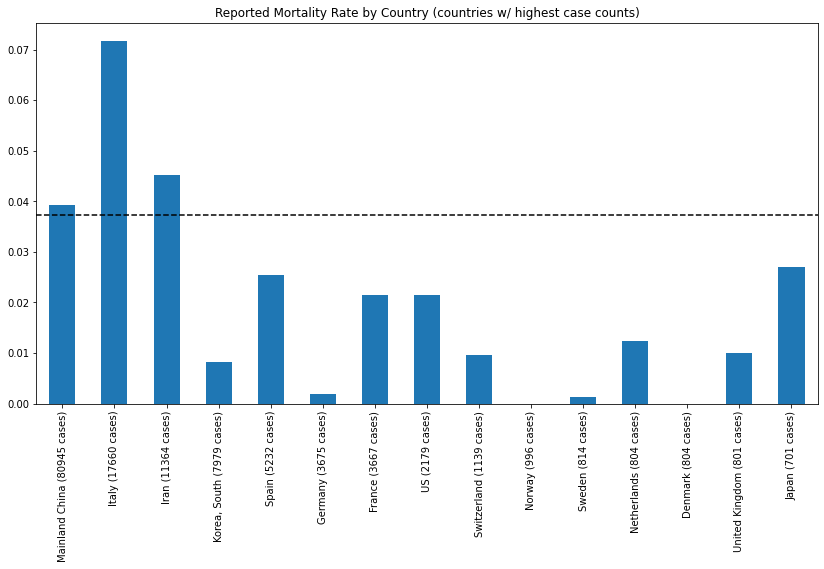

In [6]:
#collapse-hide

display(Markdown('Overall reported mortality rate: %.2f%%' % (100.0 * df['deaths'].sum() / df['cases'].sum())))

df_highest = df.sort_values('cases', ascending=False).head(15)
mortality_rate = pd.Series(
    data=(df_highest['deaths']/df_highest['cases']).values,
    index=map(lambda x: '%s (%i cases)' % (x, df_highest.loc[x]['cases']),
              df_highest.index))
ax = mortality_rate.plot.bar(
    figsize=(14,7), title='Reported Mortality Rate by Country (countries w/ highest case counts)')
ax.axhline(df['deaths'].sum() / df['cases'].sum(), color='k', ls='--')

plt.show()

# Model

Estimate COVID-19 mortality rate, controling for country factors

In [7]:
#hide

import numpy as np

import pymc3 as pm


def initialize_model(df):

    # Normalize input covariates in a way that is sensible:

    # (1) days since first case: upper
    # mu_0 to reflect asymptotic mortality rate months after outbreak
    _normalize_col(df, 'days_since_first_case', how='upper')
    # (2) CPI score: upper
    # mu_0 to reflect scenario in absence of corrupt govts
    _normalize_col(df, 'cpi_score_2019', how='upper')
    # (3) healthcare OOP spending: mean
    # not sure which way this will go
    _normalize_col(df, 'healthcare_oop_expenditure', how='mean')
    # (4) hospital beds: upper
    # more beds, more healthcare and tests
    _normalize_col(df, 'hospital_beds', how='mean')
    # (5) hci = human capital index: upper
    # HCI measures education/health; mu_0 should reflect best scenario
    _normalize_col(df, 'hci', how='mean')
    # (6) % over 65: mean
    # mu_0 to reflect average world demographic
    _normalize_col(df, 'population_perc_over65', how='mean')
    # (7) % rural: mean
    # mu_0 to reflect average world demographic
    _normalize_col(df, 'population_perc_rural', how='mean')

    n = len(df)

    covid_mortality_model = pm.Model()

    with covid_mortality_model:

        # Priors:
        mu_0 = pm.Beta('mu_0', alpha=0.3, beta=10)
        sig_0 = pm.Uniform('sig_0', lower=0.0, upper=mu_0 * (1 - mu_0))
        beta = pm.Normal('beta', mu=0, sigma=5, shape=7)
        sigma = pm.HalfNormal('sigma', sigma=5)

        # Model mu from country-wise covariates:
        # Apply logit transformation so logistic regression performed
        mu_0_logit = np.log(mu_0 / (1 - mu_0))
        mu_est = mu_0_logit + \
            beta[0] * df['days_since_first_case_normalized'].values + \
            beta[1] * df['cpi_score_2019_normalized'].values + \
            beta[2] * df['healthcare_oop_expenditure_normalized'].values + \
            beta[3] * df['hospital_beds_normalized'].values + \
            beta[4] * df['hci_normalized'].values + \
            beta[5] * df['population_perc_over65_normalized'].values + \
            beta[6] * df['population_perc_rural_normalized'].values
        mu_model_logit = pm.Normal('mu_model_logit',
                                   mu=mu_est,
                                   sigma=sigma,
                                   shape=n)
        # Transform back to probability space:
        mu_model = np.exp(mu_model_logit) / (np.exp(mu_model_logit) + 1)

        # tau_i, mortality rate for each country
        # Parametrize with (mu, sigma)
        # instead of (alpha, beta) to ease interpretability.
        tau = pm.Beta('tau', mu=mu_model, sigma=sig_0, shape=n)
        # tau = pm.Beta('tau', mu=mu_0, sigma=sig_0, shape=n)

        # Binomial likelihood:
        d_obs = pm.Binomial('d_obs',
                            n=df['cases'].values,
                            p=tau,
                            observed=df['deaths'].values)

    return covid_mortality_model


def _normalize_col(df, colname, how='mean'):
    '''
    Normalize an input column in one of 3 ways:

    * how=mean: unit normal N(0,1)
    * how=upper: normalize to [-1, 0] with highest value set to 0
    * how=lower: normalize to [0, 1] with lowest value set to 0

    Returns df modified in place with extra column added.
    '''
    colname_new = '%s_normalized' % colname
    if how == 'mean':
        mu = df[colname].mean()
        sig = df[colname].std()
        df[colname_new] = (df[colname] - mu) / sig
    elif how == 'upper':
        maxval = df[colname].max()
        minval = df[colname].min()
        df[colname_new] = (df[colname] - maxval) / (maxval - minval)
    elif how == 'lower':
        maxval = df[colname].max()
        minval = df[colname].min()
        df[colname_new] = (df[colname] - minval) / (maxval - minval)

In [8]:
#hide

# Initialize the model:
mod = initialize_model(df)

# Run MCMC sampler1
with mod:
    trace = pm.sample(300, tune=100,
                      chains=3, cores=2)

Only 300 samples in chain.


Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (3 chains in 2 jobs)


NUTS: [tau, mu_model_logit, sigma, beta, sig_0, mu_0]


Sampling 3 chains, 0 divergences:   0%|          | 0/1200 [00:00<?, ?draws/s]

Sampling 3 chains, 0 divergences:   1%|          | 10/1200 [00:00<00:13, 86.54draws/s]

Sampling 3 chains, 0 divergences:   1%|          | 13/1200 [00:00<00:24, 47.98draws/s]

Sampling 3 chains, 0 divergences:   1%|▏         | 16/1200 [00:00<00:31, 37.54draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 19/1200 [00:00<00:40, 29.12draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 22/1200 [00:00<00:41, 28.10draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 25/1200 [00:00<00:42, 27.73draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 29/1200 [00:00<00:39, 29.58draws/s]

Sampling 3 chains, 0 divergences:   3%|▎         | 33/1200 [00:00<00:38, 30.26draws/s]

Sampling 3 chains, 0 divergences:   3%|▎         | 36/1200 [00:01<00:41, 28.37draws/s]

Sampling 3 chains, 0 divergences:   3%|▎         | 39/1200 [00:01<00:48, 23.90draws/s]

Sampling 3 chains, 0 divergences:   4%|▎         | 43/1200 [00:01<00:45, 25.38draws/s]

Sampling 3 chains, 0 divergences:   4%|▍         | 46/1200 [00:01<00:50, 23.02draws/s]

Sampling 3 chains, 0 divergences:   4%|▍         | 49/1200 [00:01<00:47, 24.02draws/s]

Sampling 3 chains, 0 divergences:   4%|▍         | 52/1200 [00:01<00:47, 23.99draws/s]

Sampling 3 chains, 0 divergences:   5%|▍         | 55/1200 [00:01<00:49, 23.37draws/s]

Sampling 3 chains, 0 divergences:   5%|▍         | 59/1200 [00:02<00:47, 24.12draws/s]

Sampling 3 chains, 0 divergences:   5%|▌         | 62/1200 [00:02<00:46, 24.63draws/s]

Sampling 3 chains, 0 divergences:   5%|▌         | 65/1200 [00:02<00:46, 24.59draws/s]

Sampling 3 chains, 0 divergences:   6%|▌         | 68/1200 [00:02<00:46, 24.25draws/s]

Sampling 3 chains, 0 divergences:   6%|▌         | 73/1200 [00:02<00:45, 25.04draws/s]

Sampling 3 chains, 0 divergences:   6%|▋         | 76/1200 [00:02<00:43, 25.64draws/s]

Sampling 3 chains, 0 divergences:   7%|▋         | 79/1200 [00:02<00:42, 26.08draws/s]

Sampling 3 chains, 0 divergences:   7%|▋         | 82/1200 [00:02<00:42, 26.47draws/s]

Sampling 3 chains, 0 divergences:   7%|▋         | 85/1200 [00:03<00:42, 25.93draws/s]

Sampling 3 chains, 0 divergences:   7%|▋         | 89/1200 [00:03<00:41, 26.89draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 94/1200 [00:03<00:41, 26.60draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 97/1200 [00:03<00:43, 25.58draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 100/1200 [00:03<00:42, 25.91draws/s]

Sampling 3 chains, 0 divergences:   9%|▊         | 103/1200 [00:03<00:42, 25.73draws/s]

Sampling 3 chains, 0 divergences:   9%|▉         | 106/1200 [00:03<00:42, 25.78draws/s]

Sampling 3 chains, 0 divergences:   9%|▉         | 109/1200 [00:04<00:41, 26.22draws/s]

Sampling 3 chains, 0 divergences:   9%|▉         | 112/1200 [00:04<00:45, 24.13draws/s]

Sampling 3 chains, 0 divergences:  10%|▉         | 115/1200 [00:04<00:43, 24.68draws/s]

Sampling 3 chains, 0 divergences:  10%|█         | 120/1200 [00:04<00:37, 28.73draws/s]

Sampling 3 chains, 0 divergences:  10%|█         | 124/1200 [00:04<00:35, 30.33draws/s]

Sampling 3 chains, 0 divergences:  11%|█         | 128/1200 [00:04<00:40, 26.28draws/s]

Sampling 3 chains, 0 divergences:  11%|█         | 131/1200 [00:04<00:42, 24.90draws/s]

Sampling 3 chains, 0 divergences:  11%|█▏        | 135/1200 [00:05<00:43, 24.66draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 138/1200 [00:05<00:46, 22.84draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 141/1200 [00:05<00:45, 23.35draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 144/1200 [00:05<00:51, 20.34draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 148/1200 [00:05<00:45, 23.25draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 151/1200 [00:05<00:45, 22.88draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 154/1200 [00:05<00:45, 23.16draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 157/1200 [00:06<00:48, 21.44draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 161/1200 [00:06<00:43, 23.74draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 165/1200 [00:06<00:39, 26.48draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 168/1200 [00:06<00:40, 25.71draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 171/1200 [00:06<00:39, 26.37draws/s]

Sampling 3 chains, 0 divergences:  15%|█▍        | 176/1200 [00:06<00:34, 30.03draws/s]

Sampling 3 chains, 0 divergences:  15%|█▌        | 181/1200 [00:06<00:30, 33.66draws/s]

Sampling 3 chains, 0 divergences:  15%|█▌        | 185/1200 [00:06<00:29, 34.13draws/s]

Sampling 3 chains, 0 divergences:  16%|█▌        | 189/1200 [00:06<00:29, 34.65draws/s]

Sampling 3 chains, 0 divergences:  16%|█▌        | 194/1200 [00:07<00:27, 36.74draws/s]

Sampling 3 chains, 0 divergences:  16%|█▋        | 198/1200 [00:07<00:28, 35.48draws/s]

Sampling 3 chains, 0 divergences:  17%|█▋        | 203/1200 [00:07<00:26, 37.98draws/s]

Sampling 3 chains, 0 divergences:  17%|█▋        | 207/1200 [00:07<00:33, 29.52draws/s]

Sampling 3 chains, 0 divergences:  18%|█▊        | 211/1200 [00:07<00:31, 30.91draws/s]

Sampling 3 chains, 0 divergences:  18%|█▊        | 216/1200 [00:07<00:29, 33.65draws/s]

Sampling 3 chains, 0 divergences:  19%|█▊        | 223/1200 [00:07<00:25, 38.87draws/s]

Sampling 3 chains, 0 divergences:  19%|█▉        | 228/1200 [00:07<00:26, 36.64draws/s]

Sampling 3 chains, 0 divergences:  19%|█▉        | 233/1200 [00:08<00:25, 38.54draws/s]

Sampling 3 chains, 0 divergences:  20%|█▉        | 238/1200 [00:08<00:30, 31.38draws/s]

Sampling 3 chains, 0 divergences:  20%|██        | 242/1200 [00:08<00:29, 32.48draws/s]

Sampling 3 chains, 0 divergences:  20%|██        | 246/1200 [00:08<00:32, 29.28draws/s]

Sampling 3 chains, 0 divergences:  21%|██        | 250/1200 [00:08<00:31, 30.21draws/s]

Sampling 3 chains, 0 divergences:  21%|██        | 254/1200 [00:08<00:33, 27.88draws/s]

Sampling 3 chains, 0 divergences:  21%|██▏       | 257/1200 [00:09<00:34, 27.46draws/s]

Sampling 3 chains, 0 divergences:  22%|██▏       | 260/1200 [00:09<00:34, 27.01draws/s]

Sampling 3 chains, 0 divergences:  22%|██▏       | 264/1200 [00:09<00:32, 28.46draws/s]

Sampling 3 chains, 0 divergences:  22%|██▏       | 267/1200 [00:09<00:35, 25.94draws/s]

Sampling 3 chains, 0 divergences:  22%|██▎       | 270/1200 [00:09<00:36, 25.78draws/s]

Sampling 3 chains, 0 divergences:  23%|██▎       | 273/1200 [00:09<00:36, 25.75draws/s]

Sampling 3 chains, 0 divergences:  23%|██▎       | 276/1200 [00:09<00:44, 20.99draws/s]

Sampling 3 chains, 0 divergences:  23%|██▎       | 279/1200 [00:09<00:40, 22.52draws/s]

Sampling 3 chains, 1 divergences:  23%|██▎       | 279/1200 [00:09<00:40, 22.52draws/s]

Sampling 3 chains, 1 divergences:  24%|██▎       | 283/1200 [00:10<00:38, 23.60draws/s]

Sampling 3 chains, 1 divergences:  24%|██▍       | 286/1200 [00:10<00:39, 22.88draws/s]

Sampling 3 chains, 1 divergences:  24%|██▍       | 289/1200 [00:10<00:47, 19.20draws/s]

Sampling 3 chains, 1 divergences:  24%|██▍       | 292/1200 [00:10<00:43, 20.72draws/s]

Sampling 3 chains, 1 divergences:  25%|██▍       | 295/1200 [00:10<00:41, 21.68draws/s]

Sampling 3 chains, 1 divergences:  25%|██▍       | 298/1200 [00:10<00:41, 21.99draws/s]

Sampling 3 chains, 1 divergences:  25%|██▌       | 301/1200 [00:10<00:43, 20.50draws/s]

Sampling 3 chains, 1 divergences:  25%|██▌       | 304/1200 [00:11<00:40, 21.91draws/s]

Sampling 3 chains, 1 divergences:  26%|██▌       | 307/1200 [00:11<00:39, 22.62draws/s]

Sampling 3 chains, 1 divergences:  26%|██▌       | 310/1200 [00:11<00:40, 22.06draws/s]

Sampling 3 chains, 1 divergences:  26%|██▌       | 313/1200 [00:11<00:38, 23.17draws/s]

Sampling 3 chains, 1 divergences:  26%|██▋       | 316/1200 [00:11<00:36, 23.93draws/s]

Sampling 3 chains, 1 divergences:  27%|██▋       | 320/1200 [00:11<00:33, 26.09draws/s]

Sampling 3 chains, 2 divergences:  27%|██▋       | 322/1200 [00:11<00:33, 26.09draws/s]

Sampling 3 chains, 2 divergences:  27%|██▋       | 323/1200 [00:11<00:37, 23.34draws/s]

Sampling 3 chains, 3 divergences:  27%|██▋       | 325/1200 [00:11<00:37, 23.34draws/s]

Sampling 3 chains, 3 divergences:  27%|██▋       | 326/1200 [00:11<00:35, 24.78draws/s]

Sampling 3 chains, 3 divergences:  27%|██▋       | 329/1200 [00:12<00:37, 23.30draws/s]

Sampling 3 chains, 3 divergences:  28%|██▊       | 332/1200 [00:12<00:36, 23.83draws/s]

Sampling 3 chains, 3 divergences:  28%|██▊       | 335/1200 [00:12<00:35, 24.60draws/s]

Sampling 3 chains, 3 divergences:  28%|██▊       | 338/1200 [00:12<00:34, 25.28draws/s]

Sampling 3 chains, 3 divergences:  28%|██▊       | 341/1200 [00:12<00:45, 19.02draws/s]

Sampling 3 chains, 3 divergences:  29%|██▊       | 344/1200 [00:13<00:56, 15.26draws/s]

Sampling 3 chains, 3 divergences:  29%|██▉       | 346/1200 [00:13<01:01, 13.82draws/s]

Sampling 3 chains, 3 divergences:  29%|██▉       | 348/1200 [00:13<00:56, 14.97draws/s]

Sampling 3 chains, 3 divergences:  29%|██▉       | 350/1200 [00:13<01:01, 13.80draws/s]

Sampling 3 chains, 3 divergences:  29%|██▉       | 352/1200 [00:13<00:57, 14.72draws/s]

Sampling 3 chains, 3 divergences:  30%|██▉       | 354/1200 [00:13<00:54, 15.43draws/s]

Sampling 3 chains, 3 divergences:  30%|██▉       | 356/1200 [00:13<00:56, 14.89draws/s]

Sampling 3 chains, 3 divergences:  30%|██▉       | 358/1200 [00:13<00:53, 15.88draws/s]

Sampling 3 chains, 4 divergences:  30%|██▉       | 358/1200 [00:14<00:53, 15.88draws/s]

Sampling 3 chains, 5 divergences:  30%|██▉       | 359/1200 [00:14<00:52, 15.88draws/s]

Sampling 3 chains, 5 divergences:  30%|███       | 360/1200 [00:14<01:09, 12.11draws/s]

Sampling 3 chains, 5 divergences:  30%|███       | 362/1200 [00:14<01:15, 11.13draws/s]

Sampling 3 chains, 5 divergences:  30%|███       | 364/1200 [00:14<01:20, 10.36draws/s]

Sampling 3 chains, 5 divergences:  30%|███       | 366/1200 [00:15<01:42,  8.17draws/s]

Sampling 3 chains, 5 divergences:  31%|███       | 367/1200 [00:15<02:00,  6.90draws/s]

Sampling 3 chains, 5 divergences:  31%|███       | 368/1200 [00:15<02:32,  5.46draws/s]

Sampling 3 chains, 5 divergences:  31%|███       | 370/1200 [00:15<02:00,  6.89draws/s]

Sampling 3 chains, 5 divergences:  31%|███       | 372/1200 [00:15<01:53,  7.31draws/s]

Sampling 3 chains, 5 divergences:  31%|███       | 373/1200 [00:15<01:44,  7.92draws/s]

Sampling 3 chains, 5 divergences:  31%|███       | 374/1200 [00:16<02:13,  6.16draws/s]

Sampling 3 chains, 5 divergences:  31%|███▏      | 375/1200 [00:16<02:30,  5.47draws/s]

Sampling 3 chains, 5 divergences:  32%|███▏      | 378/1200 [00:16<02:04,  6.58draws/s]

Sampling 3 chains, 5 divergences:  32%|███▏      | 380/1200 [00:16<01:40,  8.13draws/s]

Sampling 3 chains, 5 divergences:  32%|███▏      | 382/1200 [00:16<01:25,  9.55draws/s]

Sampling 3 chains, 5 divergences:  32%|███▏      | 384/1200 [00:17<01:48,  7.50draws/s]

Sampling 3 chains, 5 divergences:  32%|███▏      | 386/1200 [00:17<01:57,  6.92draws/s]

Sampling 3 chains, 5 divergences:  32%|███▏      | 388/1200 [00:17<01:35,  8.48draws/s]

Sampling 3 chains, 5 divergences:  32%|███▎      | 390/1200 [00:17<01:21,  9.88draws/s]

Sampling 3 chains, 5 divergences:  33%|███▎      | 392/1200 [00:17<01:10, 11.42draws/s]

Sampling 3 chains, 6 divergences:  33%|███▎      | 393/1200 [00:18<01:10, 11.42draws/s]

Sampling 3 chains, 6 divergences:  33%|███▎      | 394/1200 [00:18<01:36,  8.36draws/s]

Sampling 3 chains, 6 divergences:  33%|███▎      | 396/1200 [00:18<01:58,  6.79draws/s]

Sampling 3 chains, 6 divergences:  33%|███▎      | 399/1200 [00:18<01:36,  8.32draws/s]

Sampling 3 chains, 6 divergences:  33%|███▎      | 401/1200 [00:19<01:34,  8.46draws/s]

Sampling 3 chains, 7 divergences:  33%|███▎      | 401/1200 [00:19<01:34,  8.46draws/s]

Sampling 3 chains, 7 divergences:  34%|███▎      | 403/1200 [00:19<01:37,  8.17draws/s]

Sampling 3 chains, 7 divergences:  34%|███▍      | 406/1200 [00:19<01:21,  9.72draws/s]

Sampling 3 chains, 8 divergences:  34%|███▍      | 406/1200 [00:19<01:21,  9.72draws/s]

Sampling 3 chains, 8 divergences:  34%|███▍      | 408/1200 [00:19<01:11, 11.07draws/s]

Sampling 3 chains, 8 divergences:  34%|███▍      | 410/1200 [00:20<01:30,  8.74draws/s]

Sampling 3 chains, 8 divergences:  34%|███▍      | 412/1200 [00:20<01:44,  7.51draws/s]

Sampling 3 chains, 8 divergences:  34%|███▍      | 413/1200 [00:20<02:05,  6.29draws/s]

Sampling 3 chains, 8 divergences:  35%|███▍      | 415/1200 [00:20<02:07,  6.13draws/s]

Sampling 3 chains, 8 divergences:  35%|███▍      | 416/1200 [00:21<01:55,  6.77draws/s]

Sampling 3 chains, 8 divergences:  35%|███▍      | 417/1200 [00:21<01:49,  7.15draws/s]

Sampling 3 chains, 8 divergences:  35%|███▍      | 418/1200 [00:21<02:32,  5.12draws/s]

Sampling 3 chains, 8 divergences:  35%|███▍      | 419/1200 [00:21<02:13,  5.86draws/s]

Sampling 3 chains, 8 divergences:  35%|███▌      | 421/1200 [00:21<01:48,  7.18draws/s]

Sampling 3 chains, 8 divergences:  35%|███▌      | 422/1200 [00:22<02:09,  5.99draws/s]

Sampling 3 chains, 8 divergences:  35%|███▌      | 423/1200 [00:22<01:56,  6.69draws/s]

Sampling 3 chains, 8 divergences:  35%|███▌      | 424/1200 [00:22<01:54,  6.80draws/s]

Sampling 3 chains, 8 divergences:  35%|███▌      | 425/1200 [00:22<01:50,  6.99draws/s]

Sampling 3 chains, 8 divergences:  36%|███▌      | 426/1200 [00:22<02:10,  5.93draws/s]

Sampling 3 chains, 9 divergences:  36%|███▌      | 427/1200 [00:22<02:10,  5.93draws/s]

Sampling 3 chains, 9 divergences:  36%|███▌      | 428/1200 [00:22<01:50,  6.97draws/s]

Sampling 3 chains, 9 divergences:  36%|███▌      | 429/1200 [00:22<01:57,  6.58draws/s]

Sampling 3 chains, 9 divergences:  36%|███▌      | 430/1200 [00:23<01:49,  7.05draws/s]

Sampling 3 chains, 9 divergences:  36%|███▌      | 431/1200 [00:23<01:54,  6.71draws/s]

Sampling 3 chains, 9 divergences:  36%|███▌      | 433/1200 [00:23<01:49,  7.01draws/s]

Sampling 3 chains, 9 divergences:  36%|███▋      | 436/1200 [00:23<01:38,  7.79draws/s]

Sampling 3 chains, 9 divergences:  36%|███▋      | 437/1200 [00:23<01:48,  7.00draws/s]

Sampling 3 chains, 10 divergences:  36%|███▋      | 438/1200 [00:24<01:48,  7.00draws/s]

Sampling 3 chains, 10 divergences:  37%|███▋      | 439/1200 [00:24<01:34,  8.06draws/s]

Sampling 3 chains, 10 divergences:  37%|███▋      | 440/1200 [00:24<01:32,  8.21draws/s]

Sampling 3 chains, 10 divergences:  37%|███▋      | 442/1200 [00:24<01:19,  9.49draws/s]

Sampling 3 chains, 11 divergences:  37%|███▋      | 442/1200 [00:24<01:19,  9.49draws/s]

Sampling 3 chains, 11 divergences:  37%|███▋      | 444/1200 [00:24<01:41,  7.47draws/s]

Sampling 3 chains, 11 divergences:  37%|███▋      | 445/1200 [00:25<02:02,  6.19draws/s]

Sampling 3 chains, 11 divergences:  37%|███▋      | 447/1200 [00:25<02:17,  5.46draws/s]

Sampling 3 chains, 11 divergences:  37%|███▋      | 449/1200 [00:25<02:01,  6.21draws/s]

Sampling 3 chains, 11 divergences:  38%|███▊      | 450/1200 [00:25<02:25,  5.17draws/s]

Sampling 3 chains, 11 divergences:  38%|███▊      | 451/1200 [00:26<02:23,  5.22draws/s]

Sampling 3 chains, 11 divergences:  38%|███▊      | 453/1200 [00:26<01:59,  6.23draws/s]

Sampling 3 chains, 12 divergences:  38%|███▊      | 453/1200 [00:26<01:59,  6.23draws/s]

Sampling 3 chains, 12 divergences:  38%|███▊      | 454/1200 [00:26<01:57,  6.35draws/s]

Sampling 3 chains, 13 divergences:  38%|███▊      | 454/1200 [00:26<01:57,  6.35draws/s]

Sampling 3 chains, 14 divergences:  38%|███▊      | 455/1200 [00:26<01:57,  6.35draws/s]

Sampling 3 chains, 14 divergences:  38%|███▊      | 456/1200 [00:26<01:39,  7.47draws/s]

Sampling 3 chains, 14 divergences:  38%|███▊      | 458/1200 [00:26<01:22,  9.02draws/s]

Sampling 3 chains, 15 divergences:  38%|███▊      | 458/1200 [00:26<01:22,  9.02draws/s]

Sampling 3 chains, 16 divergences:  38%|███▊      | 459/1200 [00:26<01:22,  9.02draws/s]

Sampling 3 chains, 16 divergences:  38%|███▊      | 460/1200 [00:26<01:09, 10.69draws/s]

Sampling 3 chains, 17 divergences:  38%|███▊      | 461/1200 [00:27<01:09, 10.69draws/s]

Sampling 3 chains, 17 divergences:  38%|███▊      | 462/1200 [00:27<01:14,  9.91draws/s]

Sampling 3 chains, 18 divergences:  39%|███▊      | 463/1200 [00:27<01:14,  9.91draws/s]

Sampling 3 chains, 18 divergences:  39%|███▊      | 464/1200 [00:27<01:18,  9.43draws/s]

Sampling 3 chains, 19 divergences:  39%|███▉      | 465/1200 [00:27<01:17,  9.43draws/s]

Sampling 3 chains, 19 divergences:  39%|███▉      | 466/1200 [00:27<01:11, 10.30draws/s]

Sampling 3 chains, 19 divergences:  39%|███▉      | 468/1200 [00:27<01:14,  9.77draws/s]

Sampling 3 chains, 19 divergences:  39%|███▉      | 470/1200 [00:28<01:30,  8.10draws/s]

Sampling 3 chains, 20 divergences:  39%|███▉      | 471/1200 [00:28<01:30,  8.10draws/s]

Sampling 3 chains, 21 divergences:  39%|███▉      | 472/1200 [00:28<01:29,  8.10draws/s]

Sampling 3 chains, 21 divergences:  39%|███▉      | 473/1200 [00:28<01:14,  9.76draws/s]

Sampling 3 chains, 22 divergences:  40%|███▉      | 474/1200 [00:28<01:14,  9.76draws/s]

Sampling 3 chains, 22 divergences:  40%|███▉      | 475/1200 [00:28<01:03, 11.33draws/s]

Sampling 3 chains, 23 divergences:  40%|███▉      | 475/1200 [00:28<01:03, 11.33draws/s]

Sampling 3 chains, 24 divergences:  40%|███▉      | 476/1200 [00:28<01:03, 11.33draws/s]

Sampling 3 chains, 24 divergences:  40%|███▉      | 477/1200 [00:28<01:07, 10.64draws/s]

Sampling 3 chains, 24 divergences:  40%|███▉      | 479/1200 [00:28<01:07, 10.66draws/s]

Sampling 3 chains, 25 divergences:  40%|████      | 480/1200 [00:28<01:07, 10.66draws/s]

Sampling 3 chains, 25 divergences:  40%|████      | 482/1200 [00:28<00:59, 11.98draws/s]

Sampling 3 chains, 25 divergences:  40%|████      | 484/1200 [00:29<01:01, 11.56draws/s]

Sampling 3 chains, 25 divergences:  40%|████      | 486/1200 [00:29<00:57, 12.41draws/s]

Sampling 3 chains, 26 divergences:  40%|████      | 486/1200 [00:29<00:57, 12.41draws/s]

Sampling 3 chains, 26 divergences:  41%|████      | 488/1200 [00:29<01:00, 11.84draws/s]

Sampling 3 chains, 27 divergences:  41%|████      | 489/1200 [00:29<01:00, 11.84draws/s]

Sampling 3 chains, 27 divergences:  41%|████      | 490/1200 [00:29<01:12,  9.79draws/s]

Sampling 3 chains, 27 divergences:  41%|████      | 492/1200 [00:29<01:12,  9.71draws/s]

Sampling 3 chains, 27 divergences:  41%|████      | 494/1200 [00:30<01:05, 10.81draws/s]

Sampling 3 chains, 27 divergences:  41%|████▏     | 496/1200 [00:30<01:22,  8.57draws/s]

Sampling 3 chains, 28 divergences:  41%|████▏     | 496/1200 [00:30<01:22,  8.57draws/s]

Sampling 3 chains, 28 divergences:  41%|████▏     | 497/1200 [00:30<01:55,  6.10draws/s]

Sampling 3 chains, 28 divergences:  42%|████▏     | 498/1200 [00:30<01:53,  6.19draws/s]

Sampling 3 chains, 29 divergences:  42%|████▏     | 498/1200 [00:30<01:53,  6.19draws/s]

Sampling 3 chains, 30 divergences:  42%|████▏     | 499/1200 [00:31<01:53,  6.19draws/s]

Sampling 3 chains, 30 divergences:  42%|████▏     | 500/1200 [00:31<01:46,  6.60draws/s]

Sampling 3 chains, 30 divergences:  42%|████▏     | 501/1200 [00:31<01:59,  5.83draws/s]

Sampling 3 chains, 30 divergences:  42%|████▏     | 503/1200 [00:31<02:11,  5.32draws/s]

Sampling 3 chains, 30 divergences:  42%|████▏     | 505/1200 [00:32<02:19,  4.98draws/s]

Sampling 3 chains, 30 divergences:  42%|████▏     | 507/1200 [00:32<01:51,  6.22draws/s]

Sampling 3 chains, 30 divergences:  42%|████▏     | 508/1200 [00:32<02:29,  4.62draws/s]

Sampling 3 chains, 30 divergences:  42%|████▏     | 509/1200 [00:32<02:06,  5.45draws/s]

Sampling 3 chains, 30 divergences:  42%|████▎     | 510/1200 [00:32<02:04,  5.56draws/s]

Sampling 3 chains, 30 divergences:  43%|████▎     | 511/1200 [00:33<02:09,  5.34draws/s]

Sampling 3 chains, 30 divergences:  43%|████▎     | 513/1200 [00:33<01:53,  6.03draws/s]

Sampling 3 chains, 30 divergences:  43%|████▎     | 514/1200 [00:33<02:06,  5.43draws/s]

Sampling 3 chains, 30 divergences:  43%|████▎     | 516/1200 [00:34<02:11,  5.18draws/s]

Sampling 3 chains, 31 divergences:  43%|████▎     | 518/1200 [00:34<02:11,  5.18draws/s]

Sampling 3 chains, 31 divergences:  43%|████▎     | 519/1200 [00:34<02:00,  5.63draws/s]

Sampling 3 chains, 31 divergences:  43%|████▎     | 521/1200 [00:34<01:45,  6.46draws/s]

Sampling 3 chains, 31 divergences:  44%|████▎     | 522/1200 [00:34<01:36,  7.04draws/s]

Sampling 3 chains, 31 divergences:  44%|████▎     | 523/1200 [00:34<01:34,  7.14draws/s]

Sampling 3 chains, 31 divergences:  44%|████▍     | 525/1200 [00:35<01:33,  7.22draws/s]

Sampling 3 chains, 31 divergences:  44%|████▍     | 526/1200 [00:35<01:41,  6.64draws/s]

Sampling 3 chains, 31 divergences:  44%|████▍     | 527/1200 [00:35<01:58,  5.68draws/s]

Sampling 3 chains, 31 divergences:  44%|████▍     | 528/1200 [00:35<02:09,  5.19draws/s]

Sampling 3 chains, 32 divergences:  44%|████▍     | 528/1200 [00:36<02:09,  5.19draws/s]

Sampling 3 chains, 32 divergences:  44%|████▍     | 529/1200 [00:36<02:09,  5.18draws/s]

Sampling 3 chains, 33 divergences:  44%|████▍     | 530/1200 [00:36<02:09,  5.18draws/s]

Sampling 3 chains, 33 divergences:  44%|████▍     | 531/1200 [00:36<01:48,  6.15draws/s]

Sampling 3 chains, 34 divergences:  44%|████▍     | 532/1200 [00:36<01:48,  6.15draws/s]

Sampling 3 chains, 34 divergences:  44%|████▍     | 534/1200 [00:36<01:30,  7.39draws/s]

Sampling 3 chains, 34 divergences:  45%|████▍     | 535/1200 [00:36<01:25,  7.79draws/s]

Sampling 3 chains, 34 divergences:  45%|████▍     | 537/1200 [00:36<01:11,  9.32draws/s]

Sampling 3 chains, 34 divergences:  45%|████▍     | 539/1200 [00:36<01:12,  9.16draws/s]

Sampling 3 chains, 35 divergences:  45%|████▍     | 539/1200 [00:36<01:12,  9.16draws/s]

Sampling 3 chains, 36 divergences:  45%|████▌     | 541/1200 [00:37<01:11,  9.16draws/s]

Sampling 3 chains, 36 divergences:  45%|████▌     | 542/1200 [00:37<01:00, 10.87draws/s]

Sampling 3 chains, 37 divergences:  45%|████▌     | 544/1200 [00:37<01:00, 10.87draws/s]

Sampling 3 chains, 37 divergences:  45%|████▌     | 545/1200 [00:37<00:50, 13.04draws/s]

Sampling 3 chains, 38 divergences:  46%|████▌     | 546/1200 [00:37<00:50, 13.04draws/s]

Sampling 3 chains, 38 divergences:  46%|████▌     | 547/1200 [00:37<01:15,  8.64draws/s]

Sampling 3 chains, 38 divergences:  46%|████▌     | 549/1200 [00:37<01:13,  8.84draws/s]

Sampling 3 chains, 38 divergences:  46%|████▌     | 551/1200 [00:38<01:24,  7.68draws/s]

Sampling 3 chains, 38 divergences:  46%|████▌     | 553/1200 [00:38<01:35,  6.76draws/s]

Sampling 3 chains, 38 divergences:  46%|████▋     | 555/1200 [00:38<01:49,  5.90draws/s]

Sampling 3 chains, 38 divergences:  46%|████▋     | 557/1200 [00:39<01:37,  6.57draws/s]

Sampling 3 chains, 39 divergences:  46%|████▋     | 558/1200 [00:39<01:37,  6.57draws/s]

Sampling 3 chains, 39 divergences:  47%|████▋     | 559/1200 [00:39<01:33,  6.88draws/s]

Sampling 3 chains, 40 divergences:  47%|████▋     | 559/1200 [00:39<01:33,  6.88draws/s]

Sampling 3 chains, 41 divergences:  47%|████▋     | 560/1200 [00:39<01:33,  6.88draws/s]

Sampling 3 chains, 41 divergences:  47%|████▋     | 561/1200 [00:39<01:18,  8.17draws/s]

Sampling 3 chains, 42 divergences:  47%|████▋     | 561/1200 [00:39<01:18,  8.17draws/s]

Sampling 3 chains, 42 divergences:  47%|████▋     | 564/1200 [00:39<01:05,  9.72draws/s]

Sampling 3 chains, 42 divergences:  47%|████▋     | 566/1200 [00:40<01:12,  8.69draws/s]

Sampling 3 chains, 42 divergences:  47%|████▋     | 568/1200 [00:40<01:12,  8.70draws/s]

Sampling 3 chains, 43 divergences:  47%|████▋     | 568/1200 [00:40<01:12,  8.70draws/s]

Sampling 3 chains, 43 divergences:  48%|████▊     | 570/1200 [00:40<01:03,  9.85draws/s]

Sampling 3 chains, 43 divergences:  48%|████▊     | 572/1200 [00:40<01:00, 10.31draws/s]

Sampling 3 chains, 44 divergences:  48%|████▊     | 572/1200 [00:40<01:00, 10.31draws/s]

Sampling 3 chains, 44 divergences:  48%|████▊     | 574/1200 [00:40<01:04,  9.72draws/s]

Sampling 3 chains, 45 divergences:  48%|████▊     | 574/1200 [00:40<01:04,  9.72draws/s]

Sampling 3 chains, 45 divergences:  48%|████▊     | 576/1200 [00:41<01:06,  9.36draws/s]

Sampling 3 chains, 45 divergences:  48%|████▊     | 577/1200 [00:41<01:24,  7.40draws/s]

Sampling 3 chains, 46 divergences:  48%|████▊     | 578/1200 [00:41<01:24,  7.40draws/s]

Sampling 3 chains, 47 divergences:  48%|████▊     | 579/1200 [00:41<01:23,  7.40draws/s]

Sampling 3 chains, 47 divergences:  48%|████▊     | 580/1200 [00:41<01:09,  8.89draws/s]

Sampling 3 chains, 47 divergences:  48%|████▊     | 582/1200 [00:41<01:13,  8.42draws/s]

Sampling 3 chains, 48 divergences:  48%|████▊     | 582/1200 [00:41<01:13,  8.42draws/s]

Sampling 3 chains, 48 divergences:  49%|████▊     | 583/1200 [00:41<01:23,  7.41draws/s]

Sampling 3 chains, 48 divergences:  49%|████▊     | 584/1200 [00:42<01:28,  6.98draws/s]

Sampling 3 chains, 48 divergences:  49%|████▉     | 586/1200 [00:42<01:18,  7.86draws/s]

Sampling 3 chains, 48 divergences:  49%|████▉     | 587/1200 [00:42<01:44,  5.87draws/s]

Sampling 3 chains, 48 divergences:  49%|████▉     | 589/1200 [00:42<01:29,  6.79draws/s]

Sampling 3 chains, 49 divergences:  49%|████▉     | 589/1200 [00:42<01:29,  6.79draws/s]

Sampling 3 chains, 49 divergences:  49%|████▉     | 590/1200 [00:42<01:42,  5.95draws/s]

Sampling 3 chains, 49 divergences:  49%|████▉     | 591/1200 [00:43<01:55,  5.25draws/s]

Sampling 3 chains, 49 divergences:  49%|████▉     | 592/1200 [00:43<01:42,  5.94draws/s]

Sampling 3 chains, 49 divergences:  49%|████▉     | 593/1200 [00:43<01:31,  6.62draws/s]

Sampling 3 chains, 49 divergences:  50%|████▉     | 594/1200 [00:43<02:10,  4.64draws/s]

Sampling 3 chains, 49 divergences:  50%|████▉     | 596/1200 [00:44<02:12,  4.56draws/s]

Sampling 3 chains, 49 divergences:  50%|████▉     | 598/1200 [00:44<02:01,  4.94draws/s]

Sampling 3 chains, 49 divergences:  50%|████▉     | 599/1200 [00:44<01:49,  5.49draws/s]

Sampling 3 chains, 50 divergences:  50%|████▉     | 599/1200 [00:44<01:49,  5.49draws/s]

Sampling 3 chains, 50 divergences:  50%|█████     | 600/1200 [00:44<01:48,  5.52draws/s]

Sampling 3 chains, 50 divergences:  50%|█████     | 602/1200 [00:45<01:32,  6.46draws/s]

Sampling 3 chains, 50 divergences:  50%|█████     | 603/1200 [00:45<01:30,  6.57draws/s]

Sampling 3 chains, 51 divergences:  50%|█████     | 604/1200 [00:45<01:30,  6.57draws/s]

Sampling 3 chains, 51 divergences:  50%|█████     | 605/1200 [00:45<01:14,  8.00draws/s]

Sampling 3 chains, 52 divergences:  50%|█████     | 605/1200 [00:45<01:14,  8.00draws/s]

Sampling 3 chains, 52 divergences:  50%|█████     | 606/1200 [00:45<01:15,  7.82draws/s]

Sampling 3 chains, 52 divergences:  51%|█████     | 607/1200 [00:45<01:29,  6.61draws/s]

Sampling 3 chains, 52 divergences:  51%|█████     | 609/1200 [00:45<01:16,  7.71draws/s]

Sampling 3 chains, 52 divergences:  51%|█████     | 610/1200 [00:46<01:47,  5.51draws/s]

Sampling 3 chains, 52 divergences:  51%|█████     | 611/1200 [00:46<01:34,  6.20draws/s]

Sampling 3 chains, 52 divergences:  51%|█████     | 612/1200 [00:46<02:10,  4.51draws/s]

Sampling 3 chains, 52 divergences:  51%|█████     | 614/1200 [00:46<01:50,  5.31draws/s]

Sampling 3 chains, 52 divergences:  51%|█████▏    | 616/1200 [00:47<01:55,  5.05draws/s]

Sampling 3 chains, 52 divergences:  52%|█████▏    | 619/1200 [00:47<01:27,  6.61draws/s]

Sampling 3 chains, 52 divergences:  52%|█████▏    | 621/1200 [00:47<01:40,  5.79draws/s]

Sampling 3 chains, 52 divergences:  52%|█████▏    | 622/1200 [00:47<01:30,  6.41draws/s]

Sampling 3 chains, 52 divergences:  52%|█████▏    | 623/1200 [00:48<01:22,  7.03draws/s]

Sampling 3 chains, 52 divergences:  52%|█████▏    | 624/1200 [00:48<01:20,  7.14draws/s]

Sampling 3 chains, 53 divergences:  52%|█████▏    | 624/1200 [00:48<01:20,  7.14draws/s]

Sampling 3 chains, 53 divergences:  52%|█████▏    | 625/1200 [00:48<01:31,  6.31draws/s]

Sampling 3 chains, 53 divergences:  52%|█████▏    | 627/1200 [00:48<01:25,  6.68draws/s]

Sampling 3 chains, 54 divergences:  52%|█████▏    | 627/1200 [00:48<01:25,  6.68draws/s]

Sampling 3 chains, 54 divergences:  52%|█████▏    | 628/1200 [00:48<01:31,  6.29draws/s]

Sampling 3 chains, 54 divergences:  52%|█████▏    | 629/1200 [00:49<01:42,  5.56draws/s]

Sampling 3 chains, 55 divergences:  52%|█████▏    | 629/1200 [00:49<01:42,  5.56draws/s]

Sampling 3 chains, 55 divergences:  53%|█████▎    | 631/1200 [00:49<01:33,  6.12draws/s]

Sampling 3 chains, 56 divergences:  53%|█████▎    | 631/1200 [00:49<01:33,  6.12draws/s]

Sampling 3 chains, 56 divergences:  53%|█████▎    | 634/1200 [00:49<01:15,  7.46draws/s]

Sampling 3 chains, 56 divergences:  53%|█████▎    | 636/1200 [00:49<01:07,  8.40draws/s]

Sampling 3 chains, 56 divergences:  53%|█████▎    | 638/1200 [00:49<00:56,  9.94draws/s]

Sampling 3 chains, 57 divergences:  53%|█████▎    | 638/1200 [00:49<00:56,  9.94draws/s]

Sampling 3 chains, 57 divergences:  53%|█████▎    | 640/1200 [00:49<00:54, 10.21draws/s]

Sampling 3 chains, 58 divergences:  54%|█████▎    | 642/1200 [00:50<00:54, 10.21draws/s]

Sampling 3 chains, 58 divergences:  54%|█████▎    | 643/1200 [00:50<00:51, 10.82draws/s]

Sampling 3 chains, 59 divergences:  54%|█████▎    | 643/1200 [00:50<00:51, 10.82draws/s]

Sampling 3 chains, 60 divergences:  54%|█████▎    | 644/1200 [00:50<00:51, 10.82draws/s]

Sampling 3 chains, 60 divergences:  54%|█████▍    | 645/1200 [00:50<00:47, 11.77draws/s]

Sampling 3 chains, 61 divergences:  54%|█████▍    | 645/1200 [00:50<00:47, 11.77draws/s]

Sampling 3 chains, 62 divergences:  54%|█████▍    | 646/1200 [00:50<00:47, 11.77draws/s]

Sampling 3 chains, 62 divergences:  54%|█████▍    | 647/1200 [00:50<00:42, 12.90draws/s]

Sampling 3 chains, 63 divergences:  54%|█████▍    | 648/1200 [00:50<00:42, 12.90draws/s]

Sampling 3 chains, 63 divergences:  54%|█████▍    | 651/1200 [00:50<00:39, 13.84draws/s]

Sampling 3 chains, 63 divergences:  54%|█████▍    | 653/1200 [00:50<00:37, 14.74draws/s]

Sampling 3 chains, 63 divergences:  55%|█████▍    | 655/1200 [00:50<00:34, 15.59draws/s]

Sampling 3 chains, 64 divergences:  55%|█████▍    | 655/1200 [00:50<00:34, 15.59draws/s]

Sampling 3 chains, 65 divergences:  55%|█████▍    | 656/1200 [00:50<00:34, 15.59draws/s]

Sampling 3 chains, 65 divergences:  55%|█████▍    | 658/1200 [00:51<00:31, 17.14draws/s]

Sampling 3 chains, 65 divergences:  55%|█████▌    | 660/1200 [00:51<00:32, 16.49draws/s]

Sampling 3 chains, 66 divergences:  55%|█████▌    | 664/1200 [00:51<00:32, 16.49draws/s]

Sampling 3 chains, 66 divergences:  55%|█████▌    | 665/1200 [00:51<00:26, 20.18draws/s]

Sampling 3 chains, 66 divergences:  56%|█████▌    | 668/1200 [00:51<00:34, 15.43draws/s]

Sampling 3 chains, 67 divergences:  56%|█████▌    | 669/1200 [00:51<00:34, 15.43draws/s]

Sampling 3 chains, 67 divergences:  56%|█████▌    | 671/1200 [00:51<00:30, 17.41draws/s]

Sampling 3 chains, 67 divergences:  56%|█████▌    | 674/1200 [00:51<00:36, 14.48draws/s]

Sampling 3 chains, 67 divergences:  56%|█████▋    | 676/1200 [00:52<00:34, 14.98draws/s]

Sampling 3 chains, 67 divergences:  56%|█████▋    | 678/1200 [00:52<00:38, 13.49draws/s]

Sampling 3 chains, 67 divergences:  57%|█████▋    | 682/1200 [00:52<00:34, 15.19draws/s]

Sampling 3 chains, 67 divergences:  57%|█████▋    | 684/1200 [00:52<00:41, 12.36draws/s]

Sampling 3 chains, 67 divergences:  57%|█████▋    | 687/1200 [00:52<00:35, 14.60draws/s]

Sampling 3 chains, 68 divergences:  57%|█████▋    | 687/1200 [00:52<00:35, 14.60draws/s]

Sampling 3 chains, 68 divergences:  57%|█████▋    | 689/1200 [00:52<00:33, 15.35draws/s]

Sampling 3 chains, 68 divergences:  58%|█████▊    | 692/1200 [00:53<00:32, 15.75draws/s]

Sampling 3 chains, 68 divergences:  58%|█████▊    | 694/1200 [00:53<00:35, 14.17draws/s]

Sampling 3 chains, 68 divergences:  58%|█████▊    | 696/1200 [00:53<00:34, 14.80draws/s]

Sampling 3 chains, 68 divergences:  58%|█████▊    | 699/1200 [00:53<00:29, 17.03draws/s]

Sampling 3 chains, 68 divergences:  58%|█████▊    | 702/1200 [00:53<00:27, 17.92draws/s]

Sampling 3 chains, 68 divergences:  59%|█████▊    | 704/1200 [00:53<00:28, 17.58draws/s]

Sampling 3 chains, 68 divergences:  59%|█████▉    | 707/1200 [00:53<00:24, 19.99draws/s]

Sampling 3 chains, 68 divergences:  59%|█████▉    | 710/1200 [00:54<00:23, 21.29draws/s]

Sampling 3 chains, 68 divergences:  59%|█████▉    | 713/1200 [00:54<00:27, 17.83draws/s]

Sampling 3 chains, 68 divergences:  60%|█████▉    | 715/1200 [00:54<00:27, 17.74draws/s]

Sampling 3 chains, 68 divergences:  60%|█████▉    | 717/1200 [00:54<00:27, 17.65draws/s]

Sampling 3 chains, 68 divergences:  60%|██████    | 721/1200 [00:54<00:23, 20.55draws/s]

Sampling 3 chains, 68 divergences:  60%|██████    | 724/1200 [00:54<00:32, 14.55draws/s]

Sampling 3 chains, 68 divergences:  60%|██████    | 726/1200 [00:55<00:30, 15.32draws/s]

Sampling 3 chains, 68 divergences:  61%|██████    | 728/1200 [00:55<00:29, 15.90draws/s]

Sampling 3 chains, 68 divergences:  61%|██████    | 730/1200 [00:55<00:33, 14.10draws/s]

Sampling 3 chains, 68 divergences:  61%|██████    | 732/1200 [00:55<00:31, 15.02draws/s]

Sampling 3 chains, 68 divergences:  61%|██████    | 734/1200 [00:55<00:32, 14.33draws/s]

Sampling 3 chains, 68 divergences:  61%|██████▏   | 736/1200 [00:55<00:33, 13.95draws/s]

Sampling 3 chains, 68 divergences:  62%|██████▏   | 738/1200 [00:55<00:34, 13.54draws/s]

Sampling 3 chains, 68 divergences:  62%|██████▏   | 740/1200 [00:56<00:35, 13.03draws/s]

Sampling 3 chains, 68 divergences:  62%|██████▏   | 742/1200 [00:56<00:36, 12.54draws/s]

Sampling 3 chains, 68 divergences:  62%|██████▏   | 745/1200 [00:56<00:33, 13.52draws/s]

Sampling 3 chains, 68 divergences:  62%|██████▏   | 747/1200 [00:56<00:34, 13.17draws/s]

Sampling 3 chains, 68 divergences:  62%|██████▏   | 749/1200 [00:56<00:31, 14.21draws/s]

Sampling 3 chains, 68 divergences:  63%|██████▎   | 751/1200 [00:56<00:36, 12.15draws/s]

Sampling 3 chains, 68 divergences:  63%|██████▎   | 753/1200 [00:57<00:38, 11.46draws/s]

Sampling 3 chains, 68 divergences:  63%|██████▎   | 755/1200 [00:57<00:35, 12.51draws/s]

Sampling 3 chains, 68 divergences:  63%|██████▎   | 757/1200 [00:57<00:32, 13.52draws/s]

Sampling 3 chains, 68 divergences:  63%|██████▎   | 759/1200 [00:57<00:30, 14.55draws/s]

Sampling 3 chains, 68 divergences:  63%|██████▎   | 761/1200 [00:57<00:30, 14.59draws/s]

Sampling 3 chains, 68 divergences:  64%|██████▎   | 763/1200 [00:57<00:28, 15.26draws/s]

Sampling 3 chains, 69 divergences:  64%|██████▎   | 763/1200 [00:57<00:28, 15.26draws/s]

Sampling 3 chains, 69 divergences:  64%|██████▍   | 765/1200 [00:57<00:27, 15.91draws/s]

Sampling 3 chains, 69 divergences:  64%|██████▍   | 767/1200 [00:58<00:30, 14.11draws/s]

Sampling 3 chains, 69 divergences:  64%|██████▍   | 769/1200 [00:58<00:32, 13.46draws/s]

Sampling 3 chains, 70 divergences:  64%|██████▍   | 769/1200 [00:58<00:32, 13.46draws/s]

Sampling 3 chains, 70 divergences:  64%|██████▍   | 771/1200 [00:58<00:29, 14.50draws/s]

Sampling 3 chains, 70 divergences:  64%|██████▍   | 773/1200 [00:58<00:35, 12.07draws/s]

Sampling 3 chains, 71 divergences:  64%|██████▍   | 773/1200 [00:58<00:35, 12.07draws/s]

Sampling 3 chains, 71 divergences:  65%|██████▍   | 775/1200 [00:58<00:33, 12.80draws/s]

Sampling 3 chains, 71 divergences:  65%|██████▍   | 777/1200 [00:58<00:32, 13.13draws/s]

Sampling 3 chains, 71 divergences:  65%|██████▍   | 779/1200 [00:58<00:29, 14.23draws/s]

Sampling 3 chains, 71 divergences:  65%|██████▌   | 781/1200 [00:59<00:30, 13.73draws/s]

Sampling 3 chains, 71 divergences:  65%|██████▌   | 783/1200 [00:59<00:29, 14.22draws/s]

Sampling 3 chains, 71 divergences:  65%|██████▌   | 785/1200 [00:59<00:27, 14.97draws/s]

Sampling 3 chains, 72 divergences:  65%|██████▌   | 785/1200 [00:59<00:27, 14.97draws/s]

Sampling 3 chains, 72 divergences:  66%|██████▌   | 788/1200 [00:59<00:26, 15.47draws/s]

Sampling 3 chains, 72 divergences:  66%|██████▌   | 790/1200 [00:59<00:32, 12.64draws/s]

Sampling 3 chains, 73 divergences:  66%|██████▌   | 790/1200 [00:59<00:32, 12.64draws/s]

Sampling 3 chains, 73 divergences:  66%|██████▌   | 792/1200 [00:59<00:29, 13.83draws/s]

Sampling 3 chains, 73 divergences:  66%|██████▌   | 794/1200 [00:59<00:27, 14.63draws/s]

Sampling 3 chains, 73 divergences:  66%|██████▋   | 796/1200 [01:00<00:27, 14.71draws/s]

Sampling 3 chains, 73 divergences:  66%|██████▋   | 798/1200 [01:00<00:26, 15.28draws/s]

Sampling 3 chains, 74 divergences:  66%|██████▋   | 798/1200 [01:00<00:26, 15.28draws/s]

Sampling 3 chains, 74 divergences:  67%|██████▋   | 800/1200 [01:00<00:25, 15.50draws/s]

Sampling 3 chains, 75 divergences:  67%|██████▋   | 800/1200 [01:00<00:25, 15.50draws/s]

Sampling 3 chains, 76 divergences:  67%|██████▋   | 801/1200 [01:00<00:25, 15.50draws/s]

Sampling 3 chains, 76 divergences:  67%|██████▋   | 802/1200 [01:00<00:25, 15.58draws/s]

Sampling 3 chains, 77 divergences:  67%|██████▋   | 802/1200 [01:00<00:25, 15.58draws/s]

Sampling 3 chains, 77 divergences:  67%|██████▋   | 804/1200 [01:00<00:27, 14.48draws/s]

Sampling 3 chains, 78 divergences:  67%|██████▋   | 805/1200 [01:00<00:27, 14.48draws/s]

Sampling 3 chains, 78 divergences:  67%|██████▋   | 806/1200 [01:00<00:31, 12.57draws/s]

Sampling 3 chains, 78 divergences:  67%|██████▋   | 808/1200 [01:01<00:41,  9.39draws/s]

Sampling 3 chains, 78 divergences:  68%|██████▊   | 810/1200 [01:01<00:42,  9.27draws/s]

Sampling 3 chains, 78 divergences:  68%|██████▊   | 812/1200 [01:01<00:51,  7.50draws/s]

Sampling 3 chains, 78 divergences:  68%|██████▊   | 814/1200 [01:01<00:43,  8.89draws/s]

Sampling 3 chains, 79 divergences:  68%|██████▊   | 814/1200 [01:02<00:43,  8.89draws/s]

Sampling 3 chains, 79 divergences:  68%|██████▊   | 816/1200 [01:02<00:43,  8.85draws/s]

Sampling 3 chains, 79 divergences:  68%|██████▊   | 818/1200 [01:02<00:36, 10.43draws/s]

Sampling 3 chains, 79 divergences:  68%|██████▊   | 820/1200 [01:02<00:38,  9.81draws/s]

Sampling 3 chains, 80 divergences:  68%|██████▊   | 820/1200 [01:02<00:38,  9.81draws/s]

Sampling 3 chains, 80 divergences:  68%|██████▊   | 822/1200 [01:02<00:33, 11.24draws/s]

Sampling 3 chains, 80 divergences:  69%|██████▊   | 824/1200 [01:03<00:48,  7.74draws/s]

Sampling 3 chains, 80 divergences:  69%|██████▉   | 826/1200 [01:03<00:46,  8.03draws/s]

Sampling 3 chains, 80 divergences:  69%|██████▉   | 827/1200 [01:03<00:57,  6.48draws/s]

Sampling 3 chains, 80 divergences:  69%|██████▉   | 829/1200 [01:03<00:46,  7.96draws/s]

Sampling 3 chains, 80 divergences:  69%|██████▉   | 831/1200 [01:04<00:52,  7.06draws/s]

Sampling 3 chains, 80 divergences:  69%|██████▉   | 832/1200 [01:04<00:48,  7.66draws/s]

Sampling 3 chains, 80 divergences:  69%|██████▉   | 833/1200 [01:04<00:47,  7.67draws/s]

Sampling 3 chains, 80 divergences:  70%|██████▉   | 834/1200 [01:04<00:57,  6.37draws/s]

Sampling 3 chains, 80 divergences:  70%|██████▉   | 836/1200 [01:04<00:52,  6.98draws/s]

Sampling 3 chains, 80 divergences:  70%|██████▉   | 837/1200 [01:04<01:00,  5.96draws/s]

Sampling 3 chains, 80 divergences:  70%|██████▉   | 838/1200 [01:05<00:56,  6.42draws/s]

Sampling 3 chains, 80 divergences:  70%|███████   | 840/1200 [01:05<00:45,  7.93draws/s]

Sampling 3 chains, 80 divergences:  70%|███████   | 842/1200 [01:05<00:55,  6.41draws/s]

Sampling 3 chains, 80 divergences:  70%|███████   | 844/1200 [01:05<00:51,  6.96draws/s]

Sampling 3 chains, 80 divergences:  70%|███████   | 846/1200 [01:05<00:42,  8.42draws/s]

Sampling 3 chains, 80 divergences:  71%|███████   | 848/1200 [01:06<00:41,  8.57draws/s]

Sampling 3 chains, 80 divergences:  71%|███████   | 850/1200 [01:06<00:46,  7.50draws/s]

Sampling 3 chains, 80 divergences:  71%|███████   | 851/1200 [01:06<00:45,  7.73draws/s]

Sampling 3 chains, 80 divergences:  71%|███████   | 852/1200 [01:06<00:43,  8.01draws/s]

Sampling 3 chains, 80 divergences:  71%|███████   | 854/1200 [01:06<00:42,  8.12draws/s]

Sampling 3 chains, 80 divergences:  71%|███████▏  | 856/1200 [01:07<00:53,  6.42draws/s]

Sampling 3 chains, 80 divergences:  72%|███████▏  | 858/1200 [01:07<00:48,  7.04draws/s]

Sampling 3 chains, 80 divergences:  72%|███████▏  | 859/1200 [01:07<00:57,  5.95draws/s]

Sampling 3 chains, 80 divergences:  72%|███████▏  | 861/1200 [01:08<01:03,  5.31draws/s]

Sampling 3 chains, 80 divergences:  72%|███████▏  | 863/1200 [01:08<00:56,  6.00draws/s]

Sampling 3 chains, 80 divergences:  72%|███████▏  | 864/1200 [01:08<01:09,  4.85draws/s]

Sampling 3 chains, 81 divergences:  72%|███████▏  | 864/1200 [01:08<01:09,  4.85draws/s]

Sampling 3 chains, 81 divergences:  72%|███████▏  | 866/1200 [01:09<00:59,  5.60draws/s]

Sampling 3 chains, 81 divergences:  72%|███████▏  | 868/1200 [01:09<00:54,  6.14draws/s]

Sampling 3 chains, 82 divergences:  72%|███████▏  | 868/1200 [01:09<00:54,  6.14draws/s]

Sampling 3 chains, 82 divergences:  72%|███████▏  | 869/1200 [01:09<00:55,  5.99draws/s]

Sampling 3 chains, 82 divergences:  73%|███████▎  | 871/1200 [01:09<00:50,  6.57draws/s]

Sampling 3 chains, 82 divergences:  73%|███████▎  | 872/1200 [01:10<00:57,  5.73draws/s]

Sampling 3 chains, 82 divergences:  73%|███████▎  | 874/1200 [01:10<00:51,  6.38draws/s]

Sampling 3 chains, 82 divergences:  73%|███████▎  | 875/1200 [01:10<00:57,  5.67draws/s]

Sampling 3 chains, 82 divergences:  73%|███████▎  | 877/1200 [01:10<00:45,  7.11draws/s]

Sampling 3 chains, 82 divergences:  73%|███████▎  | 878/1200 [01:10<00:43,  7.40draws/s]

Sampling 3 chains, 82 divergences:  73%|███████▎  | 879/1200 [01:10<00:53,  5.99draws/s]

Sampling 3 chains, 82 divergences:  73%|███████▎  | 880/1200 [01:11<00:51,  6.27draws/s]

Sampling 3 chains, 82 divergences:  73%|███████▎  | 881/1200 [01:11<01:04,  4.92draws/s]

Sampling 3 chains, 82 divergences:  74%|███████▎  | 882/1200 [01:11<00:59,  5.37draws/s]

Sampling 3 chains, 82 divergences:  74%|███████▎  | 884/1200 [01:12<01:02,  5.04draws/s]

Sampling 3 chains, 82 divergences:  74%|███████▍  | 885/1200 [01:12<00:53,  5.90draws/s]

Sampling 3 chains, 83 divergences:  74%|███████▍  | 885/1200 [01:12<00:53,  5.90draws/s]

Sampling 3 chains, 83 divergences:  74%|███████▍  | 887/1200 [01:12<00:43,  7.18draws/s]

Sampling 3 chains, 83 divergences:  74%|███████▍  | 889/1200 [01:12<00:51,  5.99draws/s]

Sampling 3 chains, 83 divergences:  74%|███████▍  | 891/1200 [01:13<00:59,  5.22draws/s]

Sampling 3 chains, 83 divergences:  74%|███████▍  | 893/1200 [01:13<01:01,  4.98draws/s]

Sampling 3 chains, 83 divergences:  75%|███████▍  | 895/1200 [01:14<01:05,  4.66draws/s]

Sampling 3 chains, 83 divergences:  75%|███████▍  | 897/1200 [01:14<01:06,  4.56draws/s]

Sampling 3 chains, 83 divergences:  75%|███████▍  | 899/1200 [01:14<00:58,  5.13draws/s]

Sampling 3 chains, 83 divergences:  75%|███████▌  | 900/1200 [01:15<00:56,  5.28draws/s]

Sampling 3 chains, 83 divergences:  75%|███████▌  | 901/1200 [01:15<01:04,  4.63draws/s]

Sampling 3 chains, 83 divergences:  75%|███████▌  | 902/1200 [01:15<00:59,  4.99draws/s]

Sampling 3 chains, 83 divergences:  75%|███████▌  | 904/1200 [01:15<00:55,  5.38draws/s]

Sampling 3 chains, 83 divergences:  75%|███████▌  | 905/1200 [01:15<00:51,  5.69draws/s]

Sampling 3 chains, 83 divergences:  76%|███████▌  | 906/1200 [01:16<01:02,  4.69draws/s]

Sampling 3 chains, 83 divergences:  76%|███████▌  | 907/1200 [01:16<00:56,  5.18draws/s]

Sampling 3 chains, 83 divergences:  76%|███████▌  | 909/1200 [01:16<00:52,  5.50draws/s]

Sampling 3 chains, 83 divergences:  76%|███████▌  | 910/1200 [01:16<00:48,  5.95draws/s]

Sampling 3 chains, 83 divergences:  76%|███████▌  | 912/1200 [01:17<00:47,  6.03draws/s]

Sampling 3 chains, 83 divergences:  76%|███████▌  | 913/1200 [01:17<00:46,  6.16draws/s]

Sampling 3 chains, 84 divergences:  76%|███████▌  | 913/1200 [01:17<00:46,  6.16draws/s]

Sampling 3 chains, 85 divergences:  76%|███████▋  | 915/1200 [01:17<00:46,  6.16draws/s]

Sampling 3 chains, 85 divergences:  76%|███████▋  | 917/1200 [01:17<00:38,  7.34draws/s]

Sampling 3 chains, 85 divergences:  77%|███████▋  | 919/1200 [01:17<00:36,  7.76draws/s]

Sampling 3 chains, 86 divergences:  77%|███████▋  | 919/1200 [01:18<00:36,  7.76draws/s]

Sampling 3 chains, 86 divergences:  77%|███████▋  | 920/1200 [01:18<00:44,  6.35draws/s]

Sampling 3 chains, 86 divergences:  77%|███████▋  | 922/1200 [01:18<00:35,  7.88draws/s]

Sampling 3 chains, 86 divergences:  77%|███████▋  | 924/1200 [01:18<00:29,  9.43draws/s]

Sampling 3 chains, 87 divergences:  77%|███████▋  | 924/1200 [01:18<00:29,  9.43draws/s]

Sampling 3 chains, 87 divergences:  77%|███████▋  | 926/1200 [01:18<00:29,  9.24draws/s]

Sampling 3 chains, 87 divergences:  77%|███████▋  | 928/1200 [01:18<00:29,  9.29draws/s]

Sampling 3 chains, 88 divergences:  77%|███████▋  | 929/1200 [01:19<00:29,  9.29draws/s]

Sampling 3 chains, 88 divergences:  78%|███████▊  | 930/1200 [01:19<00:32,  8.30draws/s]

Sampling 3 chains, 88 divergences:  78%|███████▊  | 931/1200 [01:19<00:38,  7.06draws/s]

Sampling 3 chains, 88 divergences:  78%|███████▊  | 932/1200 [01:19<00:45,  5.92draws/s]

Sampling 3 chains, 88 divergences:  78%|███████▊  | 934/1200 [01:19<00:40,  6.58draws/s]

Sampling 3 chains, 88 divergences:  78%|███████▊  | 935/1200 [01:19<00:41,  6.43draws/s]

Sampling 3 chains, 88 divergences:  78%|███████▊  | 936/1200 [01:20<00:53,  4.93draws/s]

Sampling 3 chains, 89 divergences:  78%|███████▊  | 937/1200 [01:20<00:53,  4.93draws/s]

Sampling 3 chains, 89 divergences:  78%|███████▊  | 938/1200 [01:20<00:44,  5.91draws/s]

Sampling 3 chains, 89 divergences:  78%|███████▊  | 939/1200 [01:20<00:49,  5.27draws/s]

Sampling 3 chains, 89 divergences:  78%|███████▊  | 941/1200 [01:21<00:52,  4.95draws/s]

Sampling 3 chains, 89 divergences:  79%|███████▊  | 943/1200 [01:21<00:47,  5.37draws/s]

Sampling 3 chains, 89 divergences:  79%|███████▊  | 944/1200 [01:21<00:45,  5.58draws/s]

Sampling 3 chains, 90 divergences:  79%|███████▊  | 944/1200 [01:21<00:45,  5.58draws/s]

Sampling 3 chains, 90 divergences:  79%|███████▉  | 946/1200 [01:21<00:40,  6.26draws/s]

Sampling 3 chains, 91 divergences:  79%|███████▉  | 946/1200 [01:21<00:40,  6.26draws/s]

Sampling 3 chains, 91 divergences:  79%|███████▉  | 947/1200 [01:21<00:47,  5.36draws/s]

Sampling 3 chains, 91 divergences:  79%|███████▉  | 949/1200 [01:22<00:41,  6.05draws/s]

Sampling 3 chains, 91 divergences:  79%|███████▉  | 951/1200 [01:22<00:39,  6.37draws/s]

Sampling 3 chains, 92 divergences:  79%|███████▉  | 952/1200 [01:22<00:38,  6.37draws/s]

Sampling 3 chains, 92 divergences:  79%|███████▉  | 953/1200 [01:22<00:32,  7.50draws/s]

Sampling 3 chains, 92 divergences:  80%|███████▉  | 955/1200 [01:22<00:27,  8.84draws/s]

Sampling 3 chains, 92 divergences:  80%|███████▉  | 957/1200 [01:22<00:25,  9.44draws/s]

Sampling 3 chains, 93 divergences:  80%|███████▉  | 957/1200 [01:23<00:25,  9.44draws/s]

Sampling 3 chains, 93 divergences:  80%|███████▉  | 959/1200 [01:23<00:27,  8.85draws/s]

Sampling 3 chains, 93 divergences:  80%|████████  | 960/1200 [01:23<00:29,  8.24draws/s]

Sampling 3 chains, 93 divergences:  80%|████████  | 962/1200 [01:23<00:24,  9.72draws/s]

Sampling 3 chains, 94 divergences:  80%|████████  | 962/1200 [01:23<00:24,  9.72draws/s]

Sampling 3 chains, 95 divergences:  80%|████████  | 963/1200 [01:23<00:24,  9.72draws/s]

Sampling 3 chains, 96 divergences:  80%|████████  | 964/1200 [01:23<00:24,  9.72draws/s]

Sampling 3 chains, 97 divergences:  80%|████████  | 965/1200 [01:23<00:24,  9.72draws/s]

Sampling 3 chains, 97 divergences:  80%|████████  | 966/1200 [01:23<00:24,  9.64draws/s]

Sampling 3 chains, 98 divergences:  80%|████████  | 966/1200 [01:23<00:24,  9.64draws/s]

Sampling 3 chains, 99 divergences:  81%|████████  | 967/1200 [01:24<00:24,  9.64draws/s]

Sampling 3 chains, 99 divergences:  81%|████████  | 968/1200 [01:24<00:22, 10.54draws/s]

Sampling 3 chains, 100 divergences:  81%|████████  | 968/1200 [01:24<00:22, 10.54draws/s]

Sampling 3 chains, 100 divergences:  81%|████████  | 970/1200 [01:24<00:26,  8.57draws/s]

Sampling 3 chains, 101 divergences:  81%|████████  | 970/1200 [01:24<00:26,  8.57draws/s]

Sampling 3 chains, 101 divergences:  81%|████████  | 972/1200 [01:24<00:24,  9.16draws/s]

Sampling 3 chains, 102 divergences:  81%|████████  | 972/1200 [01:24<00:24,  9.16draws/s]

Sampling 3 chains, 103 divergences:  81%|████████  | 973/1200 [01:24<00:24,  9.16draws/s]

Sampling 3 chains, 104 divergences:  81%|████████  | 974/1200 [01:24<00:24,  9.16draws/s]

Sampling 3 chains, 104 divergences:  81%|████████▏ | 975/1200 [01:24<00:20, 10.89draws/s]

Sampling 3 chains, 105 divergences:  81%|████████▏ | 975/1200 [01:24<00:20, 10.89draws/s]

Sampling 3 chains, 106 divergences:  81%|████████▏ | 976/1200 [01:25<00:20, 10.89draws/s]

Sampling 3 chains, 106 divergences:  81%|████████▏ | 977/1200 [01:25<00:24,  9.15draws/s]

Sampling 3 chains, 106 divergences:  82%|████████▏ | 979/1200 [01:25<00:24,  9.00draws/s]

Sampling 3 chains, 107 divergences:  82%|████████▏ | 979/1200 [01:25<00:24,  9.00draws/s]

Sampling 3 chains, 108 divergences:  82%|████████▏ | 980/1200 [01:25<00:24,  9.00draws/s]

Sampling 3 chains, 108 divergences:  82%|████████▏ | 981/1200 [01:25<00:23,  9.35draws/s]

Sampling 3 chains, 108 divergences:  82%|████████▏ | 983/1200 [01:25<00:21,  9.97draws/s]

Sampling 3 chains, 109 divergences:  82%|████████▏ | 984/1200 [01:25<00:21,  9.97draws/s]

Sampling 3 chains, 109 divergences:  82%|████████▏ | 985/1200 [01:25<00:20, 10.71draws/s]

Sampling 3 chains, 110 divergences:  82%|████████▏ | 985/1200 [01:25<00:20, 10.71draws/s]

Sampling 3 chains, 111 divergences:  82%|████████▏ | 986/1200 [01:25<00:19, 10.71draws/s]

Sampling 3 chains, 111 divergences:  82%|████████▏ | 987/1200 [01:25<00:18, 11.22draws/s]

Sampling 3 chains, 112 divergences:  82%|████████▏ | 988/1200 [01:26<00:18, 11.22draws/s]

Sampling 3 chains, 112 divergences:  82%|████████▎ | 990/1200 [01:26<00:18, 11.32draws/s]

Sampling 3 chains, 112 divergences:  83%|████████▎ | 992/1200 [01:26<00:20,  9.99draws/s]

Sampling 3 chains, 112 divergences:  83%|████████▎ | 994/1200 [01:26<00:28,  7.15draws/s]

Sampling 3 chains, 112 divergences:  83%|████████▎ | 995/1200 [01:27<00:47,  4.34draws/s]

Sampling 3 chains, 112 divergences:  83%|████████▎ | 997/1200 [01:27<00:40,  4.96draws/s]

Sampling 3 chains, 112 divergences:  83%|████████▎ | 998/1200 [01:27<00:42,  4.79draws/s]

Sampling 3 chains, 113 divergences:  83%|████████▎ | 999/1200 [01:27<00:41,  4.79draws/s]

Sampling 3 chains, 113 divergences:  83%|████████▎ | 1000/1200 [01:27<00:33,  5.95draws/s]

Sampling 3 chains, 113 divergences:  83%|████████▎ | 1001/1200 [01:28<00:36,  5.46draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▎ | 1002/1200 [01:28<00:38,  5.16draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▎ | 1003/1200 [01:28<00:40,  4.90draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▎ | 1004/1200 [01:28<00:41,  4.73draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▍ | 1005/1200 [01:29<00:42,  4.58draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▍ | 1006/1200 [01:29<00:42,  4.55draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▍ | 1007/1200 [01:29<00:55,  3.47draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▍ | 1008/1200 [01:30<01:04,  2.98draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▍ | 1009/1200 [01:30<00:57,  3.33draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▍ | 1010/1200 [01:30<00:53,  3.55draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▍ | 1011/1200 [01:31<01:03,  2.98draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▍ | 1012/1200 [01:31<00:56,  3.31draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▍ | 1013/1200 [01:31<00:52,  3.53draws/s]

Sampling 3 chains, 113 divergences:  84%|████████▍ | 1014/1200 [01:31<00:49,  3.77draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▍ | 1015/1200 [01:32<00:47,  3.92draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▍ | 1016/1200 [01:32<00:45,  4.06draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▍ | 1017/1200 [01:32<00:44,  4.12draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▍ | 1018/1200 [01:32<00:43,  4.23draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▍ | 1019/1200 [01:32<00:43,  4.20draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▌ | 1020/1200 [01:33<00:43,  4.12draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▌ | 1021/1200 [01:33<00:42,  4.24draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▌ | 1022/1200 [01:33<00:41,  4.27draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▌ | 1023/1200 [01:34<00:53,  3.33draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▌ | 1024/1200 [01:34<00:48,  3.61draws/s]

Sampling 3 chains, 113 divergences:  85%|████████▌ | 1025/1200 [01:34<00:45,  3.83draws/s]

Sampling 3 chains, 113 divergences:  86%|████████▌ | 1026/1200 [01:34<00:43,  3.98draws/s]

Sampling 3 chains, 113 divergences:  86%|████████▌ | 1027/1200 [01:35<00:53,  3.22draws/s]

Sampling 3 chains, 113 divergences:  86%|████████▌ | 1028/1200 [01:35<00:49,  3.50draws/s]

Sampling 3 chains, 113 divergences:  86%|████████▌ | 1029/1200 [01:35<00:46,  3.66draws/s]

Sampling 3 chains, 114 divergences:  86%|████████▌ | 1029/1200 [01:35<00:46,  3.66draws/s]

Sampling 3 chains, 114 divergences:  86%|████████▌ | 1030/1200 [01:35<00:38,  4.45draws/s]

Sampling 3 chains, 115 divergences:  86%|████████▌ | 1030/1200 [01:35<00:38,  4.45draws/s]

Sampling 3 chains, 115 divergences:  86%|████████▌ | 1031/1200 [01:35<00:31,  5.28draws/s]

Sampling 3 chains, 115 divergences:  86%|████████▌ | 1032/1200 [01:36<00:34,  4.83draws/s]

Sampling 3 chains, 116 divergences:  86%|████████▌ | 1032/1200 [01:36<00:34,  4.83draws/s]

Sampling 3 chains, 116 divergences:  86%|████████▌ | 1033/1200 [01:36<00:34,  4.87draws/s]

Sampling 3 chains, 116 divergences:  86%|████████▌ | 1034/1200 [01:36<00:34,  4.75draws/s]

Sampling 3 chains, 116 divergences:  86%|████████▋ | 1035/1200 [01:36<00:35,  4.66draws/s]

Sampling 3 chains, 116 divergences:  86%|████████▋ | 1036/1200 [01:37<00:36,  4.55draws/s]

Sampling 3 chains, 117 divergences:  86%|████████▋ | 1036/1200 [01:37<00:36,  4.55draws/s]

Sampling 3 chains, 117 divergences:  86%|████████▋ | 1037/1200 [01:37<00:31,  5.11draws/s]

Sampling 3 chains, 118 divergences:  86%|████████▋ | 1037/1200 [01:37<00:31,  5.11draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1039/1200 [01:37<00:29,  5.46draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1040/1200 [01:37<00:31,  5.13draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1041/1200 [01:37<00:32,  4.96draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1042/1200 [01:38<00:34,  4.61draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1043/1200 [01:38<00:34,  4.52draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1044/1200 [01:38<00:34,  4.49draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1045/1200 [01:38<00:34,  4.44draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1046/1200 [01:39<00:35,  4.39draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1047/1200 [01:39<00:34,  4.42draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1048/1200 [01:39<00:34,  4.45draws/s]

Sampling 3 chains, 118 divergences:  87%|████████▋ | 1049/1200 [01:39<00:34,  4.40draws/s]

Sampling 3 chains, 118 divergences:  88%|████████▊ | 1050/1200 [01:40<00:44,  3.37draws/s]

Sampling 3 chains, 118 divergences:  88%|████████▊ | 1051/1200 [01:40<00:40,  3.64draws/s]

Sampling 3 chains, 118 divergences:  88%|████████▊ | 1052/1200 [01:40<00:38,  3.83draws/s]

Sampling 3 chains, 118 divergences:  88%|████████▊ | 1053/1200 [01:41<00:46,  3.13draws/s]

Sampling 3 chains, 118 divergences:  88%|████████▊ | 1054/1200 [01:41<00:42,  3.43draws/s]

Sampling 3 chains, 118 divergences:  88%|████████▊ | 1055/1200 [01:41<00:39,  3.65draws/s]

Sampling 3 chains, 118 divergences:  88%|████████▊ | 1056/1200 [01:41<00:37,  3.86draws/s]

Sampling 3 chains, 118 divergences:  88%|████████▊ | 1057/1200 [01:42<00:45,  3.17draws/s]

Sampling 3 chains, 119 divergences:  88%|████████▊ | 1057/1200 [01:42<00:45,  3.17draws/s]

Sampling 3 chains, 119 divergences:  88%|████████▊ | 1058/1200 [01:42<00:45,  3.15draws/s]

Sampling 3 chains, 119 divergences:  88%|████████▊ | 1059/1200 [01:42<00:40,  3.45draws/s]

Sampling 3 chains, 119 divergences:  88%|████████▊ | 1060/1200 [01:43<00:47,  2.96draws/s]

Sampling 3 chains, 119 divergences:  88%|████████▊ | 1061/1200 [01:43<00:42,  3.29draws/s]

Sampling 3 chains, 119 divergences:  88%|████████▊ | 1062/1200 [01:43<00:38,  3.57draws/s]

Sampling 3 chains, 119 divergences:  89%|████████▊ | 1063/1200 [01:44<00:36,  3.80draws/s]

Sampling 3 chains, 119 divergences:  89%|████████▊ | 1064/1200 [01:44<00:43,  3.13draws/s]

Sampling 3 chains, 120 divergences:  89%|████████▊ | 1064/1200 [01:44<00:43,  3.13draws/s]

Sampling 3 chains, 120 divergences:  89%|████████▉ | 1065/1200 [01:44<00:48,  2.80draws/s]

Sampling 3 chains, 120 divergences:  89%|████████▉ | 1066/1200 [01:45<00:42,  3.12draws/s]

Sampling 3 chains, 120 divergences:  89%|████████▉ | 1067/1200 [01:45<00:39,  3.40draws/s]

Sampling 3 chains, 120 divergences:  89%|████████▉ | 1068/1200 [01:45<00:36,  3.66draws/s]

Sampling 3 chains, 120 divergences:  89%|████████▉ | 1069/1200 [01:45<00:34,  3.83draws/s]

Sampling 3 chains, 120 divergences:  89%|████████▉ | 1070/1200 [01:46<00:32,  4.00draws/s]

Sampling 3 chains, 120 divergences:  89%|████████▉ | 1071/1200 [01:46<00:39,  3.24draws/s]

Sampling 3 chains, 121 divergences:  89%|████████▉ | 1071/1200 [01:46<00:39,  3.24draws/s]

Sampling 3 chains, 121 divergences:  89%|████████▉ | 1072/1200 [01:46<00:37,  3.42draws/s]

Sampling 3 chains, 122 divergences:  89%|████████▉ | 1072/1200 [01:46<00:37,  3.42draws/s]

Sampling 3 chains, 122 divergences:  90%|████████▉ | 1074/1200 [01:47<00:31,  3.96draws/s]

Sampling 3 chains, 123 divergences:  90%|████████▉ | 1074/1200 [01:47<00:31,  3.96draws/s]

Sampling 3 chains, 123 divergences:  90%|████████▉ | 1076/1200 [01:47<00:27,  4.55draws/s]

Sampling 3 chains, 123 divergences:  90%|████████▉ | 1077/1200 [01:47<00:27,  4.46draws/s]

Sampling 3 chains, 124 divergences:  90%|████████▉ | 1077/1200 [01:47<00:27,  4.46draws/s]

Sampling 3 chains, 124 divergences:  90%|████████▉ | 1079/1200 [01:47<00:23,  5.09draws/s]

Sampling 3 chains, 125 divergences:  90%|████████▉ | 1079/1200 [01:47<00:23,  5.09draws/s]

Sampling 3 chains, 126 divergences:  90%|█████████ | 1080/1200 [01:47<00:23,  5.09draws/s]

Sampling 3 chains, 127 divergences:  90%|█████████ | 1081/1200 [01:48<00:23,  5.09draws/s]

Sampling 3 chains, 127 divergences:  90%|█████████ | 1082/1200 [01:48<00:18,  6.45draws/s]

Sampling 3 chains, 128 divergences:  90%|█████████ | 1082/1200 [01:48<00:18,  6.45draws/s]

Sampling 3 chains, 128 divergences:  90%|█████████ | 1083/1200 [01:48<00:18,  6.39draws/s]

Sampling 3 chains, 128 divergences:  90%|█████████ | 1084/1200 [01:48<00:21,  5.46draws/s]

Sampling 3 chains, 128 divergences:  90%|█████████ | 1085/1200 [01:48<00:22,  5.07draws/s]

Sampling 3 chains, 128 divergences:  90%|█████████ | 1086/1200 [01:48<00:23,  4.90draws/s]

Sampling 3 chains, 128 divergences:  91%|█████████ | 1087/1200 [01:49<00:24,  4.70draws/s]

Sampling 3 chains, 128 divergences:  91%|█████████ | 1088/1200 [01:49<00:24,  4.64draws/s]

Sampling 3 chains, 128 divergences:  91%|█████████ | 1089/1200 [01:49<00:24,  4.57draws/s]

Sampling 3 chains, 128 divergences:  91%|█████████ | 1090/1200 [01:49<00:24,  4.54draws/s]

Sampling 3 chains, 128 divergences:  91%|█████████ | 1091/1200 [01:50<00:24,  4.50draws/s]

Sampling 3 chains, 128 divergences:  91%|█████████ | 1092/1200 [01:50<00:24,  4.40draws/s]

Sampling 3 chains, 128 divergences:  91%|█████████ | 1093/1200 [01:50<00:24,  4.41draws/s]

Sampling 3 chains, 128 divergences:  91%|█████████ | 1094/1200 [01:50<00:24,  4.34draws/s]

Sampling 3 chains, 129 divergences:  91%|█████████ | 1094/1200 [01:50<00:24,  4.34draws/s]

Sampling 3 chains, 129 divergences:  91%|█████████▏| 1096/1200 [01:51<00:21,  4.76draws/s]

Sampling 3 chains, 130 divergences:  91%|█████████▏| 1096/1200 [01:51<00:21,  4.76draws/s]

Sampling 3 chains, 130 divergences:  91%|█████████▏| 1097/1200 [01:51<00:23,  4.36draws/s]

Sampling 3 chains, 131 divergences:  91%|█████████▏| 1097/1200 [01:51<00:23,  4.36draws/s]

Sampling 3 chains, 131 divergences:  92%|█████████▏| 1098/1200 [01:51<00:23,  4.41draws/s]

Sampling 3 chains, 132 divergences:  92%|█████████▏| 1098/1200 [01:51<00:23,  4.41draws/s]

Sampling 3 chains, 132 divergences:  92%|█████████▏| 1099/1200 [01:51<00:20,  4.98draws/s]

Sampling 3 chains, 133 divergences:  92%|█████████▏| 1099/1200 [01:51<00:20,  4.98draws/s]

Sampling 3 chains, 133 divergences:  92%|█████████▏| 1100/1200 [01:51<00:22,  4.38draws/s]

Sampling 3 chains, 134 divergences:  92%|█████████▏| 1100/1200 [01:52<00:22,  4.38draws/s]

Sampling 3 chains, 134 divergences:  92%|█████████▏| 1101/1200 [01:52<00:21,  4.69draws/s]

Sampling 3 chains, 135 divergences:  92%|█████████▏| 1101/1200 [01:52<00:21,  4.69draws/s]

Sampling 3 chains, 135 divergences:  92%|█████████▏| 1102/1200 [01:52<00:19,  4.92draws/s]

Sampling 3 chains, 135 divergences:  92%|█████████▏| 1103/1200 [01:52<00:20,  4.78draws/s]

Sampling 3 chains, 135 divergences:  92%|█████████▏| 1104/1200 [01:52<00:20,  4.71draws/s]

Sampling 3 chains, 136 divergences:  92%|█████████▏| 1104/1200 [01:52<00:20,  4.71draws/s]

Sampling 3 chains, 136 divergences:  92%|█████████▏| 1105/1200 [01:52<00:18,  5.18draws/s]

Sampling 3 chains, 137 divergences:  92%|█████████▏| 1105/1200 [01:53<00:18,  5.18draws/s]

Sampling 3 chains, 137 divergences:  92%|█████████▏| 1106/1200 [01:53<00:17,  5.45draws/s]

Sampling 3 chains, 138 divergences:  92%|█████████▏| 1106/1200 [01:53<00:17,  5.45draws/s]

Sampling 3 chains, 138 divergences:  92%|█████████▏| 1107/1200 [01:53<00:19,  4.80draws/s]

Sampling 3 chains, 138 divergences:  92%|█████████▏| 1108/1200 [01:53<00:20,  4.60draws/s]

Sampling 3 chains, 139 divergences:  92%|█████████▏| 1108/1200 [01:53<00:20,  4.60draws/s]

Sampling 3 chains, 139 divergences:  92%|█████████▎| 1110/1200 [01:53<00:18,  4.98draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1111/1200 [01:54<00:18,  4.79draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1112/1200 [01:54<00:18,  4.65draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1113/1200 [01:54<00:18,  4.60draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1114/1200 [01:54<00:19,  4.44draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1115/1200 [01:55<00:19,  4.42draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1116/1200 [01:55<00:19,  4.41draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1117/1200 [01:55<00:18,  4.46draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1118/1200 [01:55<00:18,  4.49draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1119/1200 [01:55<00:18,  4.43draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1120/1200 [01:56<00:18,  4.42draws/s]

Sampling 3 chains, 139 divergences:  93%|█████████▎| 1121/1200 [01:56<00:22,  3.45draws/s]

Sampling 3 chains, 139 divergences:  94%|█████████▎| 1122/1200 [01:57<00:26,  2.98draws/s]

Sampling 3 chains, 140 divergences:  94%|█████████▎| 1122/1200 [01:57<00:26,  2.98draws/s]

Sampling 3 chains, 140 divergences:  94%|█████████▎| 1124/1200 [01:57<00:23,  3.25draws/s]

Sampling 3 chains, 141 divergences:  94%|█████████▎| 1124/1200 [01:57<00:23,  3.25draws/s]

Sampling 3 chains, 141 divergences:  94%|█████████▍| 1125/1200 [01:57<00:19,  3.80draws/s]

Sampling 3 chains, 142 divergences:  94%|█████████▍| 1125/1200 [01:57<00:19,  3.80draws/s]

Sampling 3 chains, 142 divergences:  94%|█████████▍| 1127/1200 [01:57<00:16,  4.45draws/s]

Sampling 3 chains, 142 divergences:  94%|█████████▍| 1128/1200 [01:58<00:16,  4.43draws/s]

Sampling 3 chains, 143 divergences:  94%|█████████▍| 1128/1200 [01:58<00:16,  4.43draws/s]

Sampling 3 chains, 143 divergences:  94%|█████████▍| 1129/1200 [01:58<00:13,  5.10draws/s]

Sampling 3 chains, 143 divergences:  94%|█████████▍| 1130/1200 [01:58<00:14,  4.96draws/s]

Sampling 3 chains, 143 divergences:  94%|█████████▍| 1131/1200 [01:58<00:14,  4.79draws/s]

Sampling 3 chains, 143 divergences:  94%|█████████▍| 1132/1200 [01:59<00:14,  4.65draws/s]

Sampling 3 chains, 143 divergences:  94%|█████████▍| 1133/1200 [01:59<00:14,  4.55draws/s]

Sampling 3 chains, 143 divergences:  94%|█████████▍| 1134/1200 [01:59<00:14,  4.56draws/s]

Sampling 3 chains, 143 divergences:  95%|█████████▍| 1135/1200 [01:59<00:14,  4.51draws/s]

Sampling 3 chains, 143 divergences:  95%|█████████▍| 1136/1200 [01:59<00:14,  4.50draws/s]

Sampling 3 chains, 143 divergences:  95%|█████████▍| 1137/1200 [02:00<00:14,  4.48draws/s]

Sampling 3 chains, 143 divergences:  95%|█████████▍| 1138/1200 [02:00<00:13,  4.46draws/s]

Sampling 3 chains, 144 divergences:  95%|█████████▍| 1138/1200 [02:00<00:13,  4.46draws/s]

Sampling 3 chains, 145 divergences:  95%|█████████▍| 1139/1200 [02:00<00:13,  4.46draws/s]

Sampling 3 chains, 146 divergences:  95%|█████████▌| 1140/1200 [02:00<00:13,  4.46draws/s]

Sampling 3 chains, 146 divergences:  95%|█████████▌| 1141/1200 [02:00<00:10,  5.37draws/s]

Sampling 3 chains, 146 divergences:  95%|█████████▌| 1142/1200 [02:00<00:11,  5.09draws/s]

Sampling 3 chains, 146 divergences:  95%|█████████▌| 1143/1200 [02:01<00:11,  4.88draws/s]

Sampling 3 chains, 146 divergences:  95%|█████████▌| 1144/1200 [02:01<00:12,  4.63draws/s]

Sampling 3 chains, 146 divergences:  95%|█████████▌| 1145/1200 [02:01<00:11,  4.59draws/s]

Sampling 3 chains, 147 divergences:  95%|█████████▌| 1145/1200 [02:01<00:11,  4.59draws/s]

Sampling 3 chains, 147 divergences:  96%|█████████▌| 1146/1200 [02:01<00:11,  4.84draws/s]

Sampling 3 chains, 147 divergences:  96%|█████████▌| 1147/1200 [02:01<00:11,  4.65draws/s]

Sampling 3 chains, 147 divergences:  96%|█████████▌| 1148/1200 [02:02<00:11,  4.57draws/s]

Sampling 3 chains, 148 divergences:  96%|█████████▌| 1148/1200 [02:02<00:11,  4.57draws/s]

Sampling 3 chains, 148 divergences:  96%|█████████▌| 1149/1200 [02:02<00:10,  4.80draws/s]

Sampling 3 chains, 148 divergences:  96%|█████████▌| 1150/1200 [02:02<00:10,  4.60draws/s]

Sampling 3 chains, 148 divergences:  96%|█████████▌| 1151/1200 [02:02<00:10,  4.57draws/s]

Sampling 3 chains, 149 divergences:  96%|█████████▌| 1151/1200 [02:03<00:10,  4.57draws/s]

Sampling 3 chains, 149 divergences:  96%|█████████▌| 1152/1200 [02:03<00:10,  4.79draws/s]

Sampling 3 chains, 149 divergences:  96%|█████████▌| 1153/1200 [02:03<00:10,  4.61draws/s]

Sampling 3 chains, 149 divergences:  96%|█████████▌| 1154/1200 [02:03<00:12,  3.54draws/s]

Sampling 3 chains, 149 divergences:  96%|█████████▋| 1155/1200 [02:04<00:14,  3.01draws/s]

Sampling 3 chains, 149 divergences:  96%|█████████▋| 1156/1200 [02:04<00:13,  3.31draws/s]

Sampling 3 chains, 149 divergences:  96%|█████████▋| 1157/1200 [02:04<00:11,  3.60draws/s]

Sampling 3 chains, 149 divergences:  96%|█████████▋| 1158/1200 [02:04<00:10,  3.82draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1159/1200 [02:05<00:10,  4.01draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1160/1200 [02:05<00:09,  4.13draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1161/1200 [02:05<00:09,  4.27draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1162/1200 [02:05<00:09,  4.20draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1163/1200 [02:05<00:08,  4.29draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1164/1200 [02:06<00:08,  4.34draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1165/1200 [02:06<00:07,  4.40draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1166/1200 [02:06<00:07,  4.45draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1167/1200 [02:06<00:07,  4.43draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1168/1200 [02:07<00:09,  3.43draws/s]

Sampling 3 chains, 149 divergences:  97%|█████████▋| 1169/1200 [02:07<00:08,  3.70draws/s]

Sampling 3 chains, 149 divergences:  98%|█████████▊| 1170/1200 [02:07<00:09,  3.09draws/s]

Sampling 3 chains, 149 divergences:  98%|█████████▊| 1171/1200 [02:08<00:08,  3.41draws/s]

Sampling 3 chains, 149 divergences:  98%|█████████▊| 1172/1200 [02:08<00:07,  3.64draws/s]

Sampling 3 chains, 149 divergences:  98%|█████████▊| 1173/1200 [02:08<00:07,  3.84draws/s]

Sampling 3 chains, 149 divergences:  98%|█████████▊| 1174/1200 [02:08<00:06,  4.02draws/s]

Sampling 3 chains, 149 divergences:  98%|█████████▊| 1175/1200 [02:09<00:06,  4.08draws/s]

Sampling 3 chains, 149 divergences:  98%|█████████▊| 1176/1200 [02:09<00:05,  4.14draws/s]

Sampling 3 chains, 149 divergences:  98%|█████████▊| 1177/1200 [02:09<00:06,  3.30draws/s]

Sampling 3 chains, 150 divergences:  98%|█████████▊| 1177/1200 [02:10<00:06,  3.30draws/s]

Sampling 3 chains, 150 divergences:  98%|█████████▊| 1178/1200 [02:10<00:07,  3.11draws/s]

Sampling 3 chains, 150 divergences:  98%|█████████▊| 1179/1200 [02:10<00:06,  3.40draws/s]

Sampling 3 chains, 150 divergences:  98%|█████████▊| 1180/1200 [02:10<00:05,  3.69draws/s]

Sampling 3 chains, 150 divergences:  98%|█████████▊| 1181/1200 [02:10<00:04,  3.92draws/s]

Sampling 3 chains, 150 divergences:  98%|█████████▊| 1182/1200 [02:11<00:04,  4.08draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▊| 1183/1200 [02:11<00:04,  4.21draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▊| 1184/1200 [02:11<00:03,  4.29draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▉| 1185/1200 [02:11<00:03,  4.34draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▉| 1186/1200 [02:11<00:03,  4.38draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▉| 1187/1200 [02:12<00:02,  4.40draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▉| 1188/1200 [02:12<00:02,  4.44draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▉| 1189/1200 [02:12<00:02,  4.45draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▉| 1190/1200 [02:12<00:02,  4.37draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▉| 1191/1200 [02:13<00:02,  4.20draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▉| 1192/1200 [02:13<00:01,  4.27draws/s]

Sampling 3 chains, 150 divergences:  99%|█████████▉| 1193/1200 [02:13<00:01,  4.32draws/s]

Sampling 3 chains, 151 divergences:  99%|█████████▉| 1193/1200 [02:13<00:01,  4.32draws/s]

Sampling 3 chains, 151 divergences: 100%|█████████▉| 1194/1200 [02:13<00:01,  4.56draws/s]

Sampling 3 chains, 152 divergences: 100%|█████████▉| 1194/1200 [02:13<00:01,  4.56draws/s]

Sampling 3 chains, 153 divergences: 100%|█████████▉| 1195/1200 [02:13<00:01,  4.56draws/s]

Sampling 3 chains, 154 divergences: 100%|█████████▉| 1196/1200 [02:13<00:00,  4.56draws/s]

Sampling 3 chains, 154 divergences: 100%|█████████▉| 1197/1200 [02:13<00:00,  5.96draws/s]

Sampling 3 chains, 155 divergences: 100%|█████████▉| 1197/1200 [02:14<00:00,  5.96draws/s]

Sampling 3 chains, 155 divergences: 100%|█████████▉| 1198/1200 [02:14<00:00,  6.11draws/s]

Sampling 3 chains, 155 divergences: 100%|█████████▉| 1199/1200 [02:14<00:00,  5.44draws/s]

Sampling 3 chains, 155 divergences: 100%|██████████| 1200/1200 [02:14<00:00,  4.97draws/s]

Sampling 3 chains, 155 divergences: 100%|██████████| 1200/1200 [02:14<00:00,  8.92draws/s]

There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


There were 53 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.2 for some parameters.


The estimated number of effective samples is smaller than 200 for some parameters.


COVID-19 Global Mortality Rate Estimation:
Posterior mean: 1.29%
Posterior median: 1.00%
95% posterior interval: (0.39%, 4.28%)

Posterior probability density for COVID-19 mortality rate, controlling for country factors:


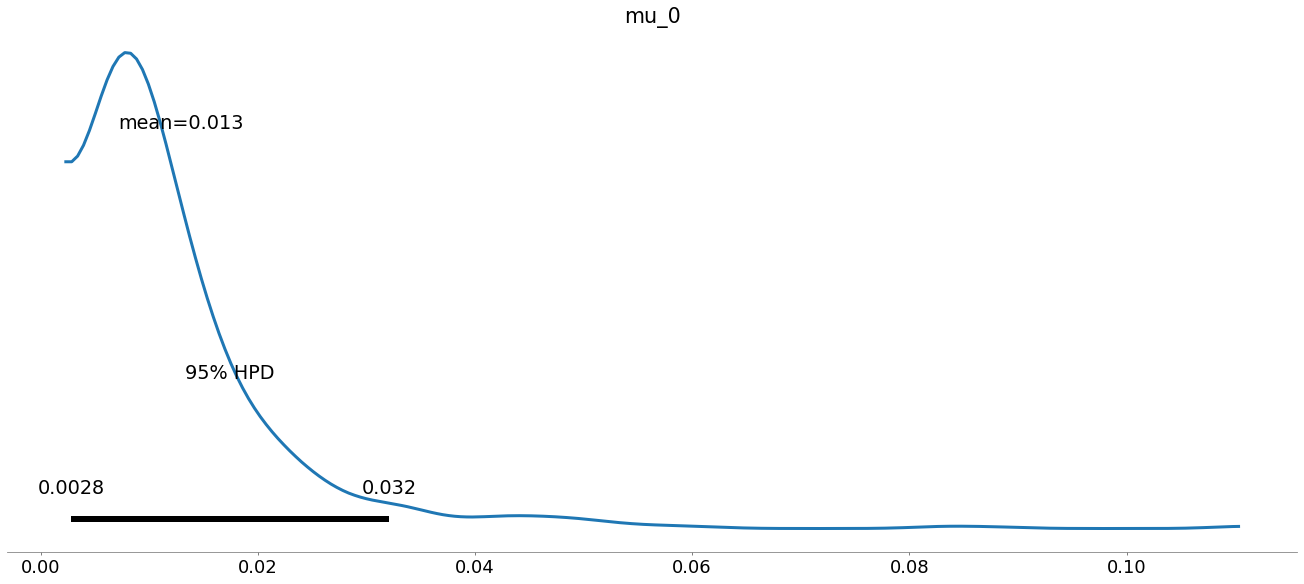

In [9]:
#collapse-hide

n_samp = len(trace['mu_0'])
mu0_summary = pm.summary(trace).loc['mu_0']
print("COVID-19 Global Mortality Rate Estimation:")
print("Posterior mean: %0.2f%%" % (100*trace['mu_0'].mean()))
print("Posterior median: %0.2f%%" % (100*np.median(trace['mu_0'])))
lower = np.sort(trace['mu_0'])[int(n_samp*0.025)]
upper = np.sort(trace['mu_0'])[int(n_samp*0.975)]
print("95%% posterior interval: (%0.2f%%, %0.2f%%)" % (100*lower, 100*upper))
print("")

# Posterior plot for mu0
print('Posterior probability density for COVID-19 mortality rate, controlling for country factors:')
ax = pm.plot_posterior(trace, var_names=['mu_0'], figsize=(18, 8), textsize=18,
                       credible_interval=0.95, bw=3.0, lw=3, kind='kde')

## Magnitude and Significance of Factors 

For bias in reported COVID-19 mortality rate

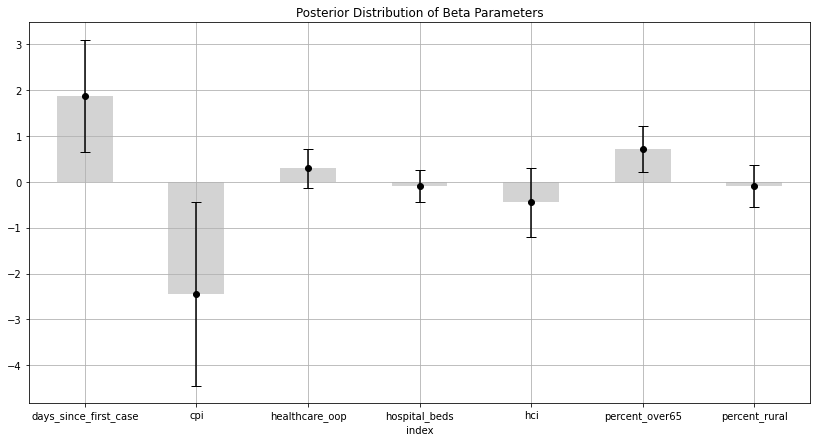

In [10]:
#collapse-hide

# Posterior summary for the beta parameters:
beta_summary = pm.summary(trace).head(7)
beta_summary.index = ['days_since_first_case', 'cpi', 'healthcare_oop', 'hospital_beds', 'hci', 'percent_over65', 'percent_rural']
beta_summary.reset_index(drop=False, inplace=True)

err_vals = ((beta_summary['hpd_3%'] - beta_summary['mean']).values,
            (beta_summary['hpd_97%'] - beta_summary['mean']).values)
ax = beta_summary.plot(x='index', y='mean', kind='bar', figsize=(14, 7),
                 title='Posterior Distribution of Beta Parameters',
                 yerr=err_vals, color='lightgrey',
                 legend=False, grid=True,
                 capsize=5)
beta_summary.plot(x='index', y='mean', color='k', marker='o', linestyle='None',
                  ax=ax, grid=True, legend=False, xlim=plt.gca().get_xlim())

plt.savefig('../images/corvid-mortality.png')

# About This Analysis

This analysis was done by [Joseph Richards](https://twitter.com/joeyrichar)

In this project[^3], we attempt to estimate the true mortality rate[^1] for COVID-19 while controlling for country-level covariates[^2][^4] such as:
* age of outbreak in the country
* transparency of the country's government
* access to healthcare
* demographics such as age of population and rural vs. urban

## Interpretation of Country-Level Parameters 

1. days_since_first_case - positive (very statistically significant).  As time since outbreak increases, expected mortality rate **increases**, as expected.
2. cpi - negative (statistically significant).  As government transparency increases, expected mortality rate **decreases**.  This may mean that less transparent governments under-report cases, hence inflating the mortality rate.
3. healthcare avg. out-of-pocket spending - no significant trend.
4. hospital beds per capita - no significant trend.
5. Human Capital Index - no significant trend (slightly negative = mortality rates decrease with increased mobilization of the country)
6. percent over 65 - positive (statistically significant).  As population age increases, the mortality rate also **increases**, as expected.
7. percent rural - no significant trend.


[^1]: As of March 10, the **overall reported mortality rate is 3.5%**.  However, this figure does not account for **systematic biases in case reporting and testing**.  The observed mortality of COVID-19 has varied widely from country to country (as of early March 2020).  For instance, as of March 10, mortality rates have ranged from < 0.1% in places like Germany (1100+ cases) to upwards of 5% in Italy (9000+ cases) and 3.9% in China (80k+ cases).

[^2]: The point of our modelling work here is to **try to understand and correct for the country-to-country differences that may cause the observed discrepancies in COVID-19 country-wide mortality rates**.  That way we can "undo" those biases and try to **pin down an overall *real* mortality rate**.

[^3]: Full details about the model are available at:  https://github.com/jwrichar/COVID19-mortality

[^4]: The affects of these parameters are subject to change as more data are collected.
            